In [13]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [14]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo42010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20040_sx1.fits'],
      dtype='<U66')

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20020_x1d.fits
[92.17609]


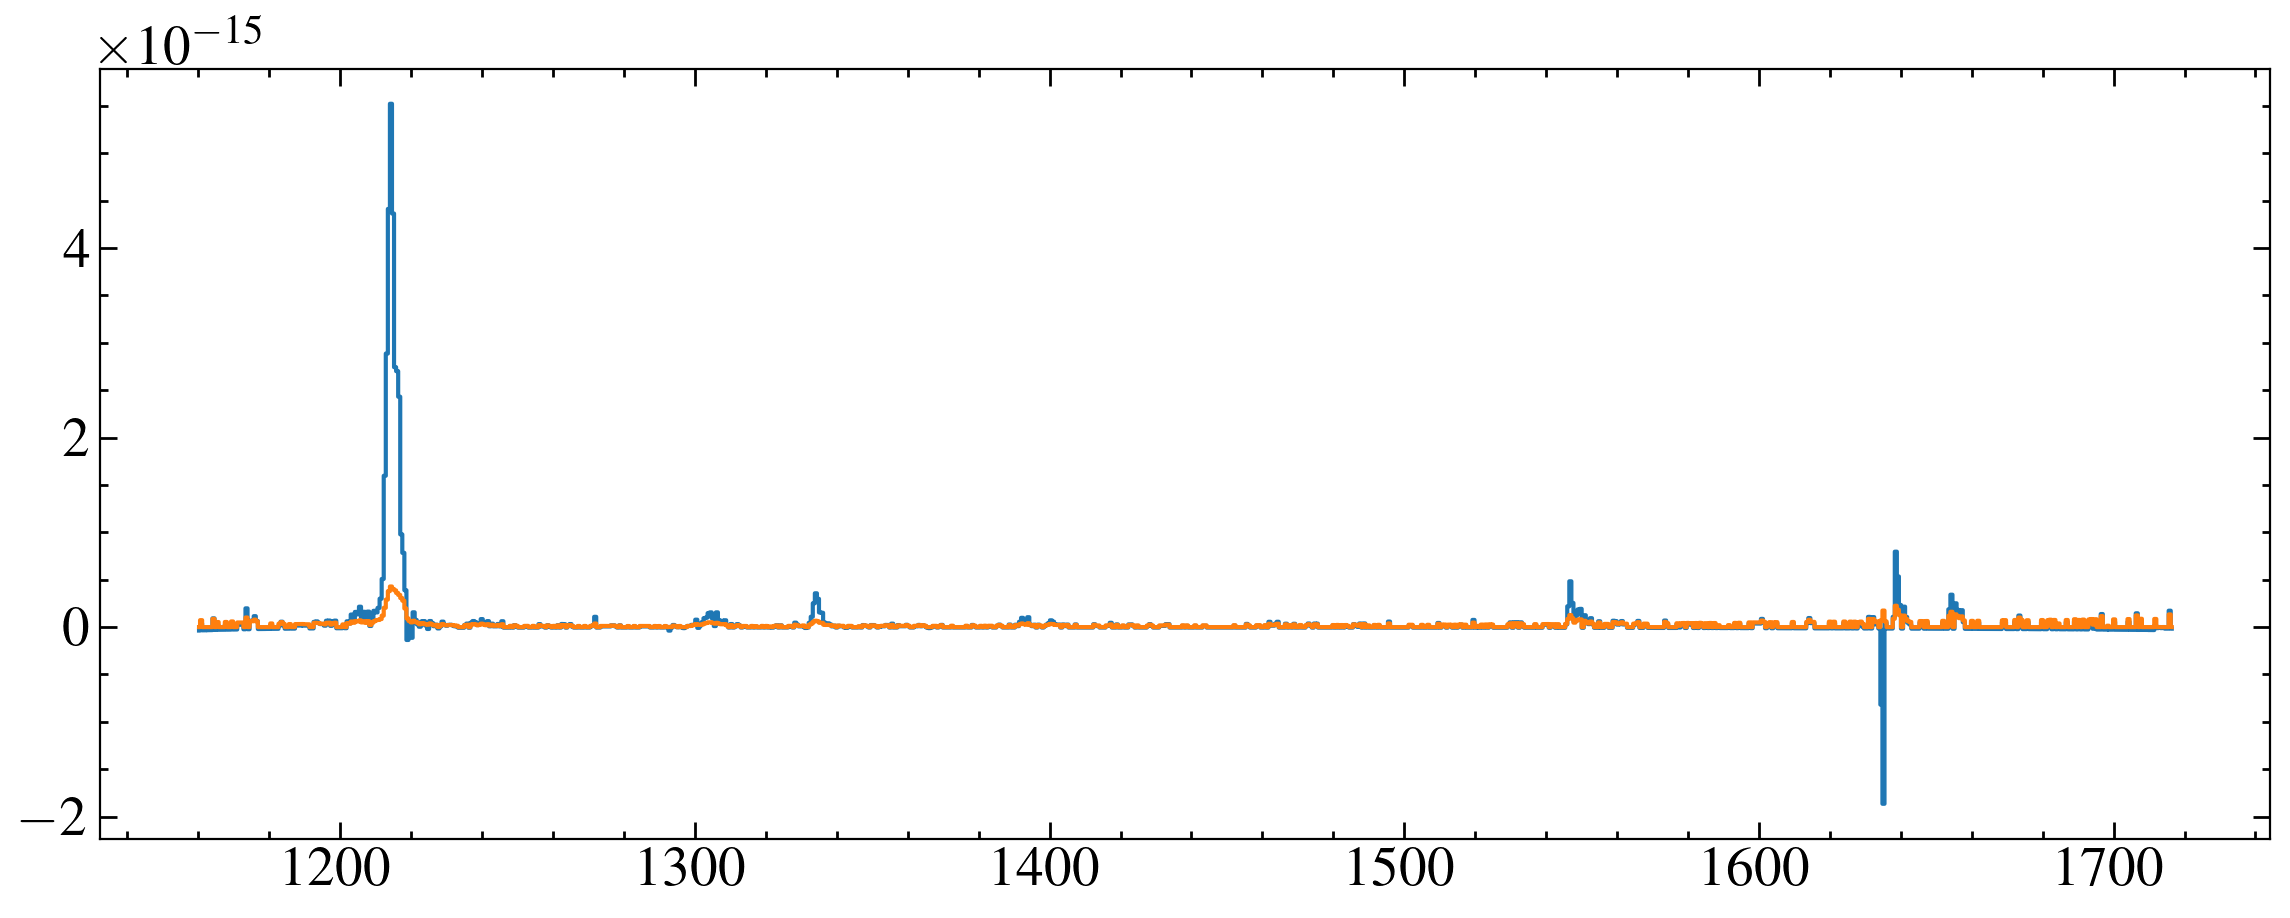

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20030_x1d.fits
[498.31918]


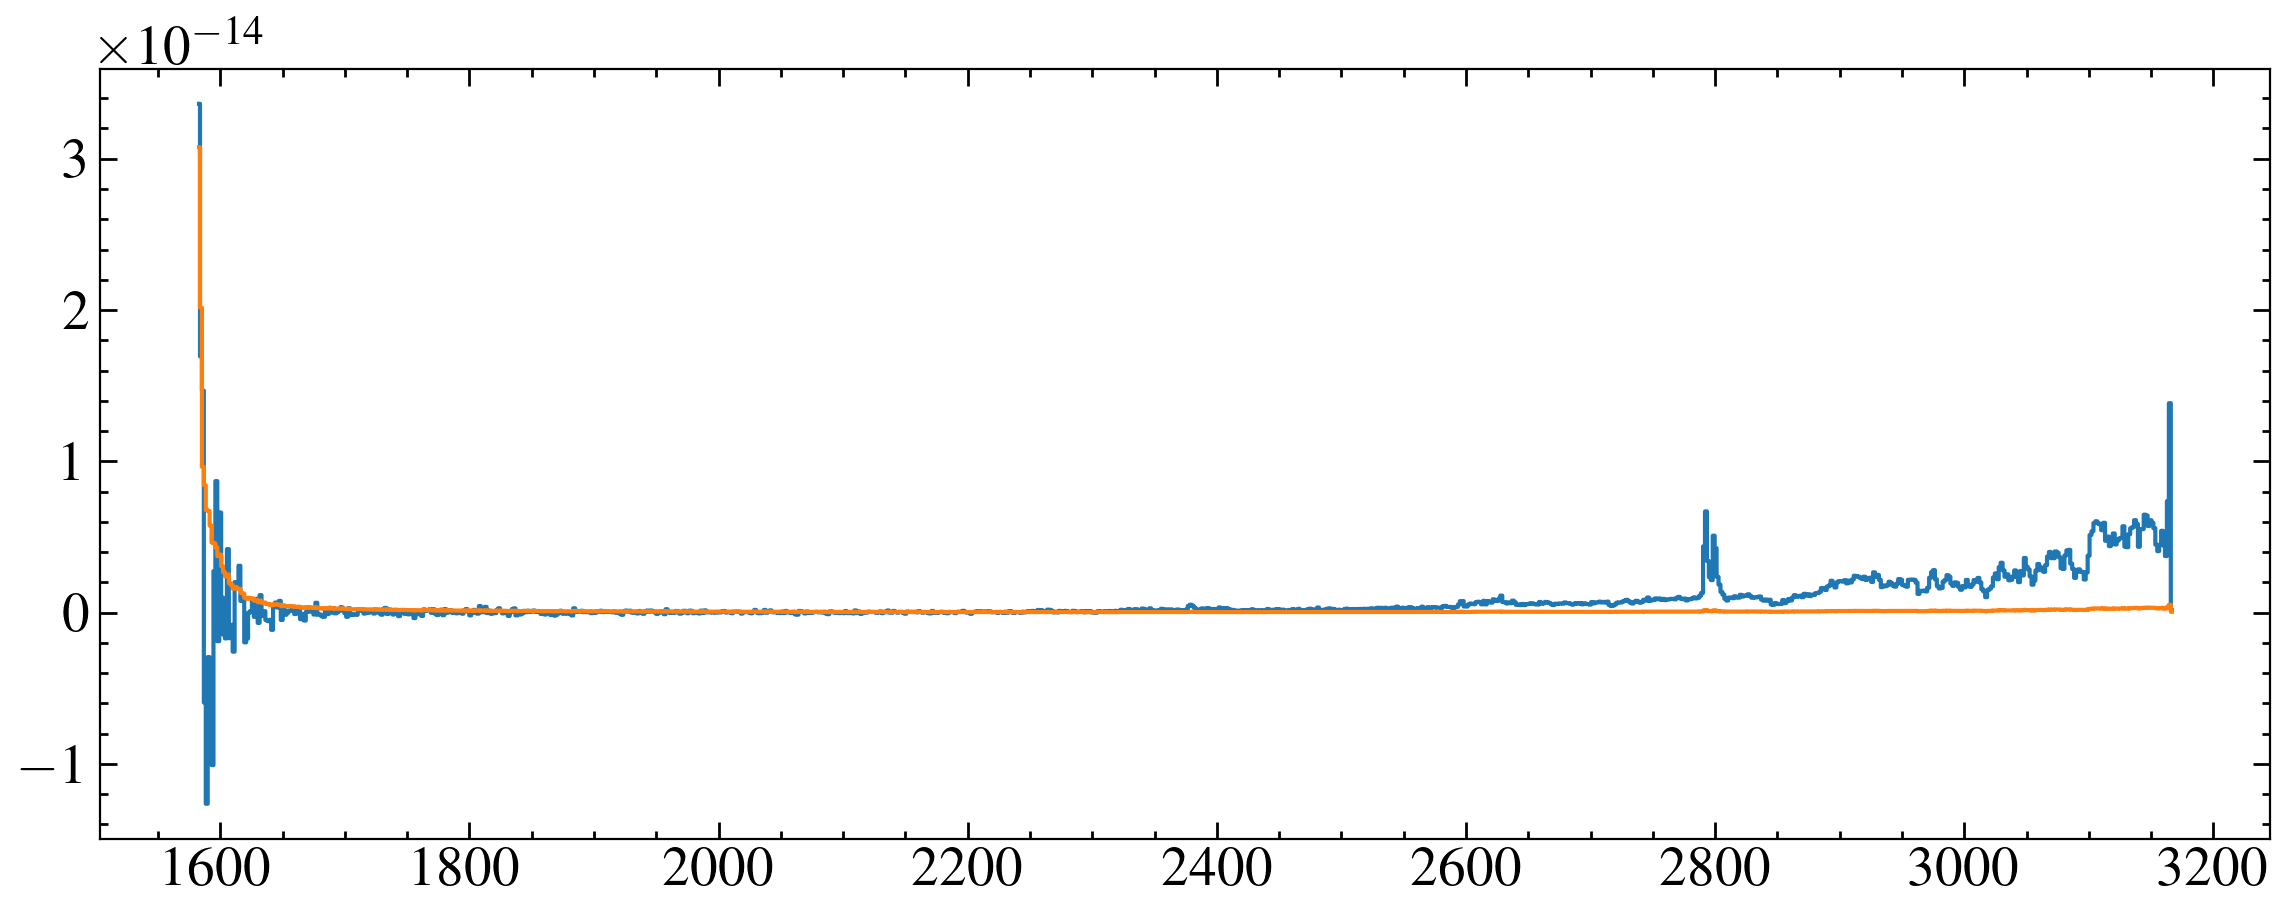

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo42010_x1d.fits
[130.67415]


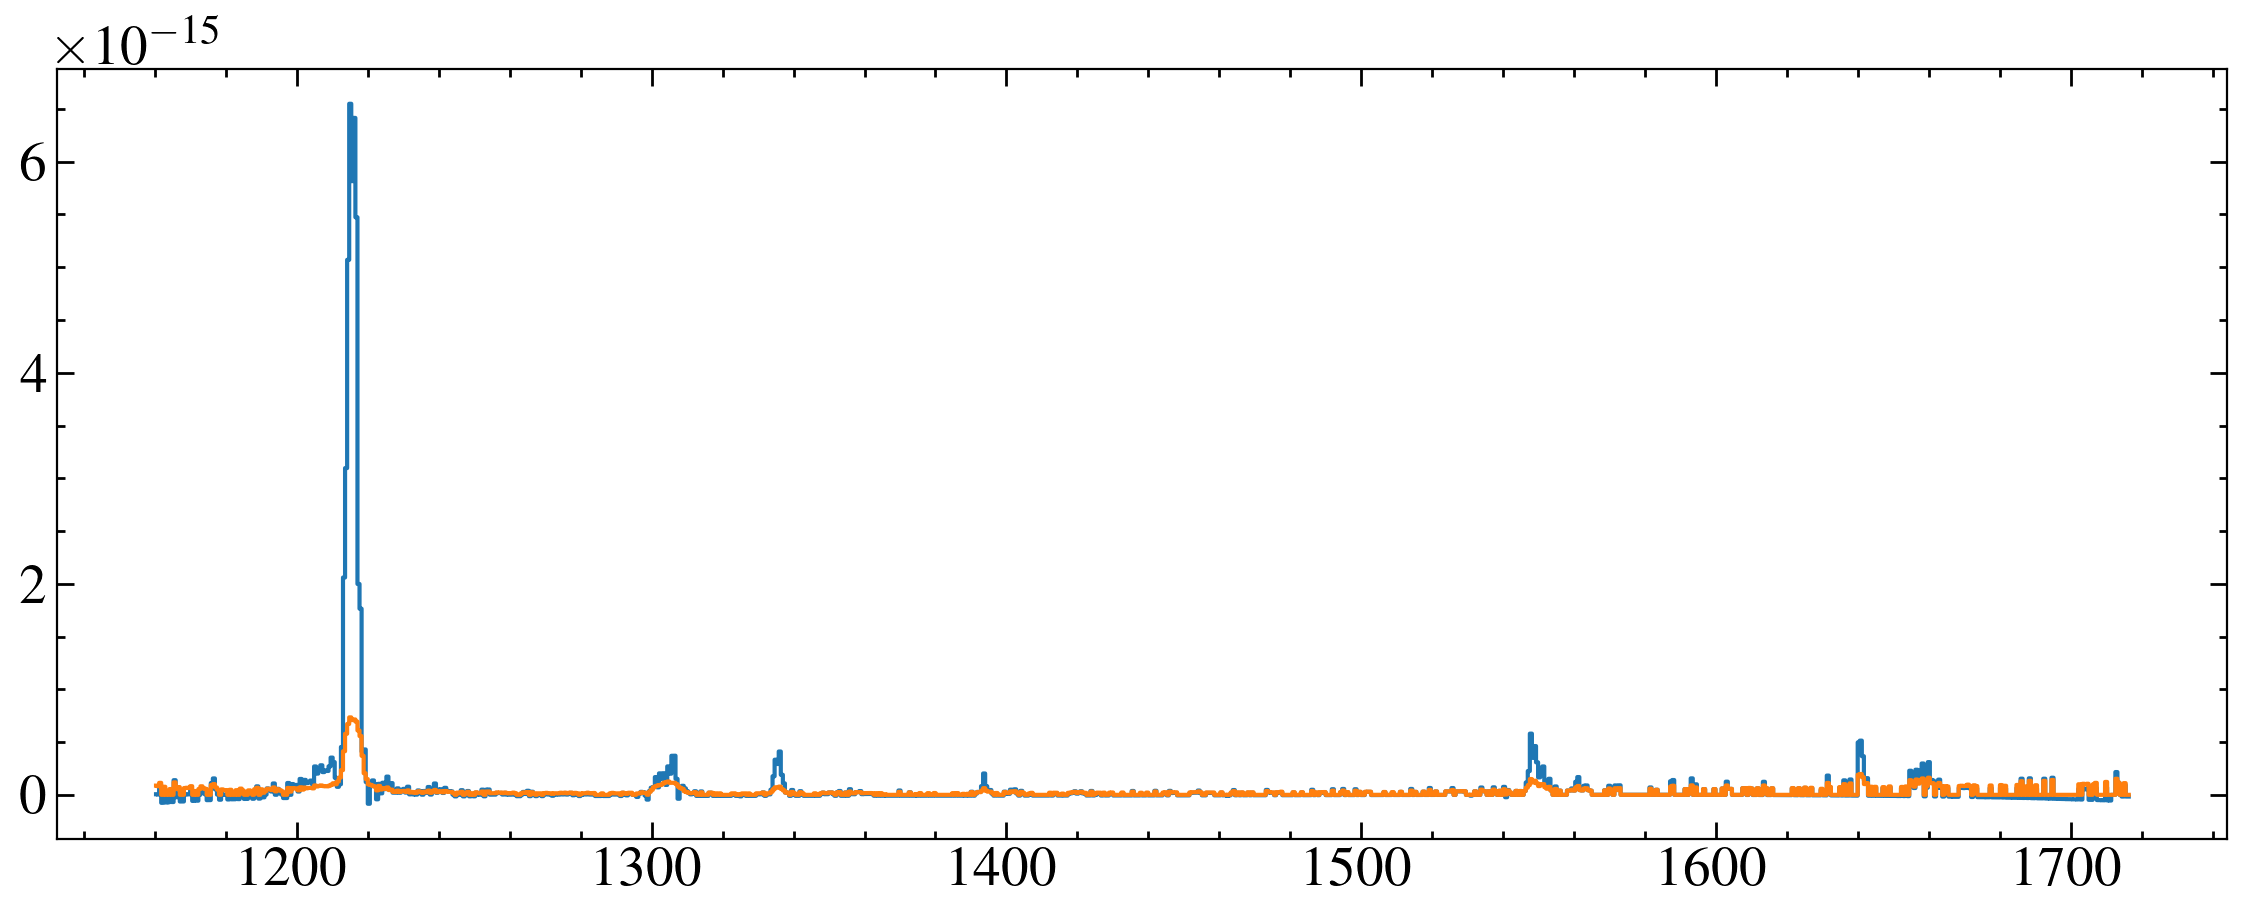

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20040_sx1.fits
[895.0867]


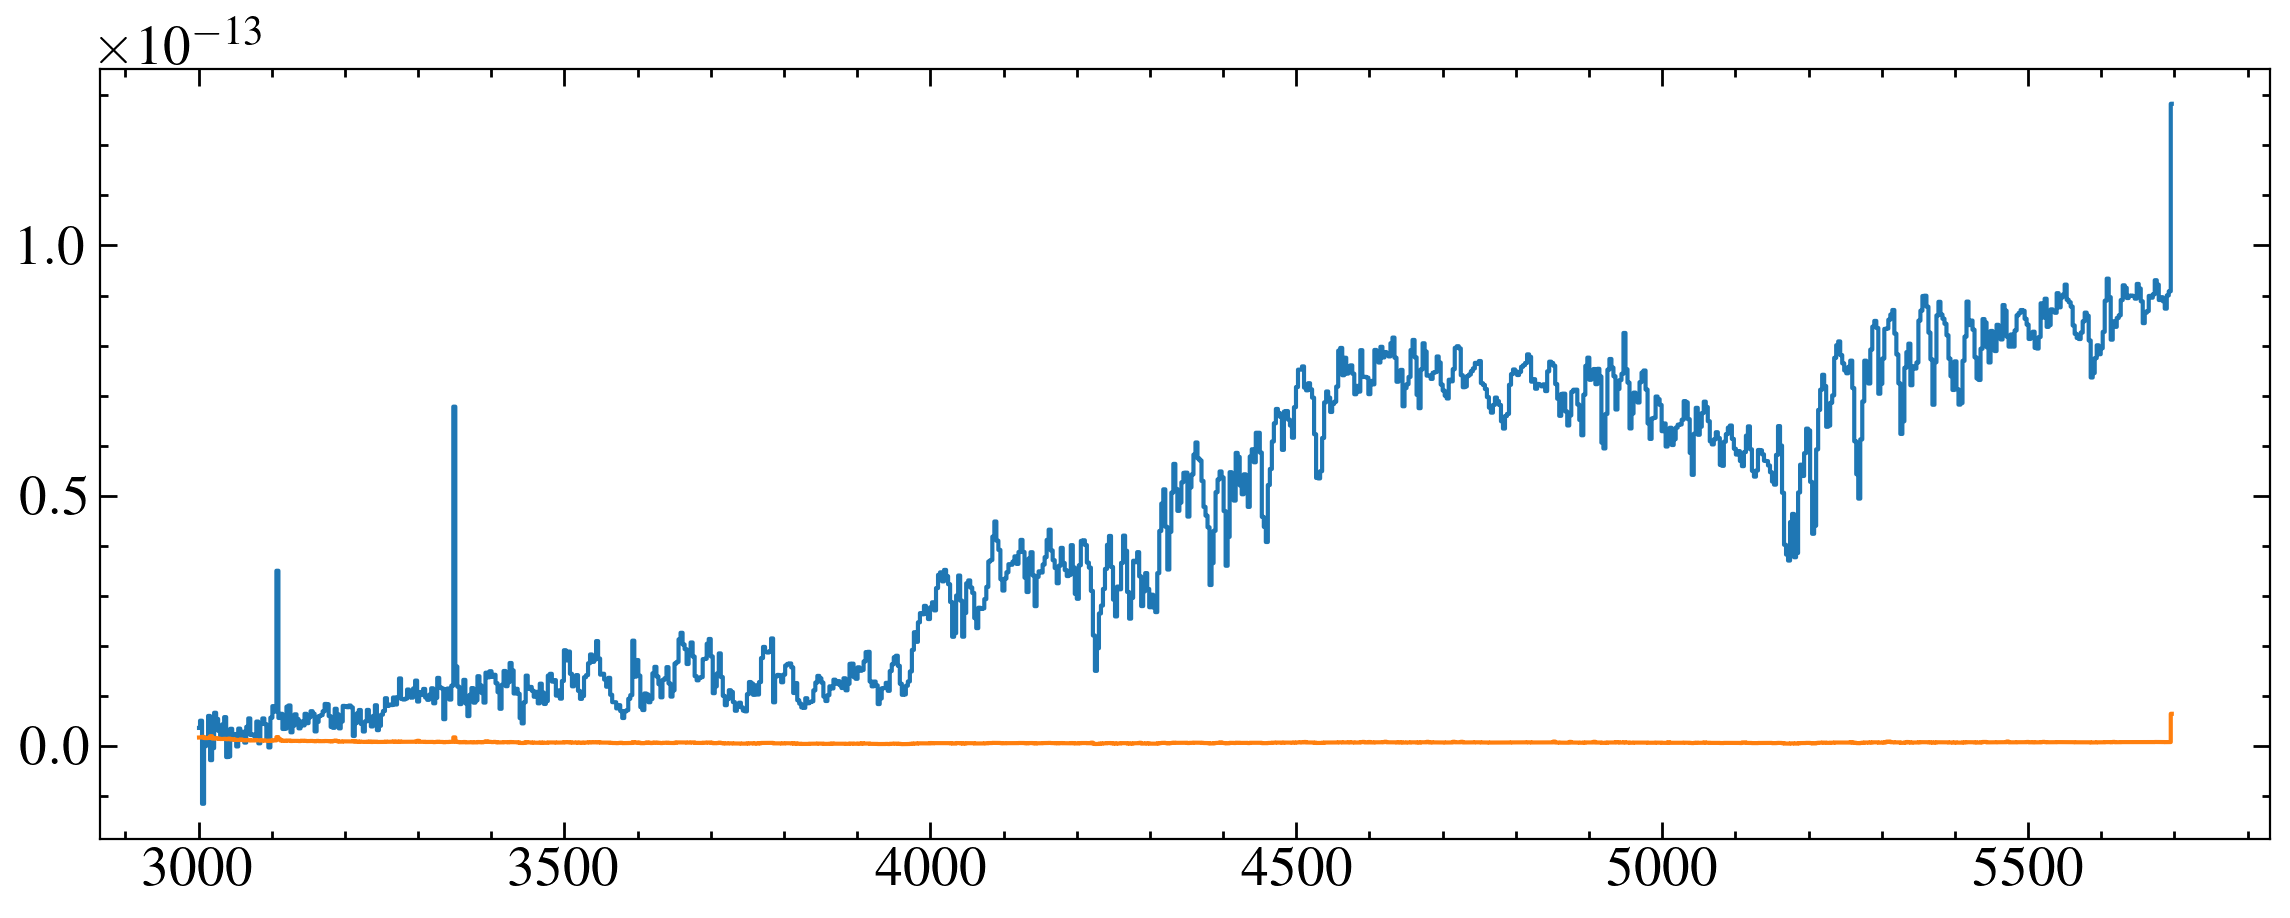

In [15]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    # print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    for dt in data:
        w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
        if grating == 'G430L':
            mask = w > 3000
        else:
            mask = w > 1160
        
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid', c='C0')
        plt.step(w, e, where='mid', c='C1')
        # plt.yscale('log')
    plt.show()

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-17)

/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


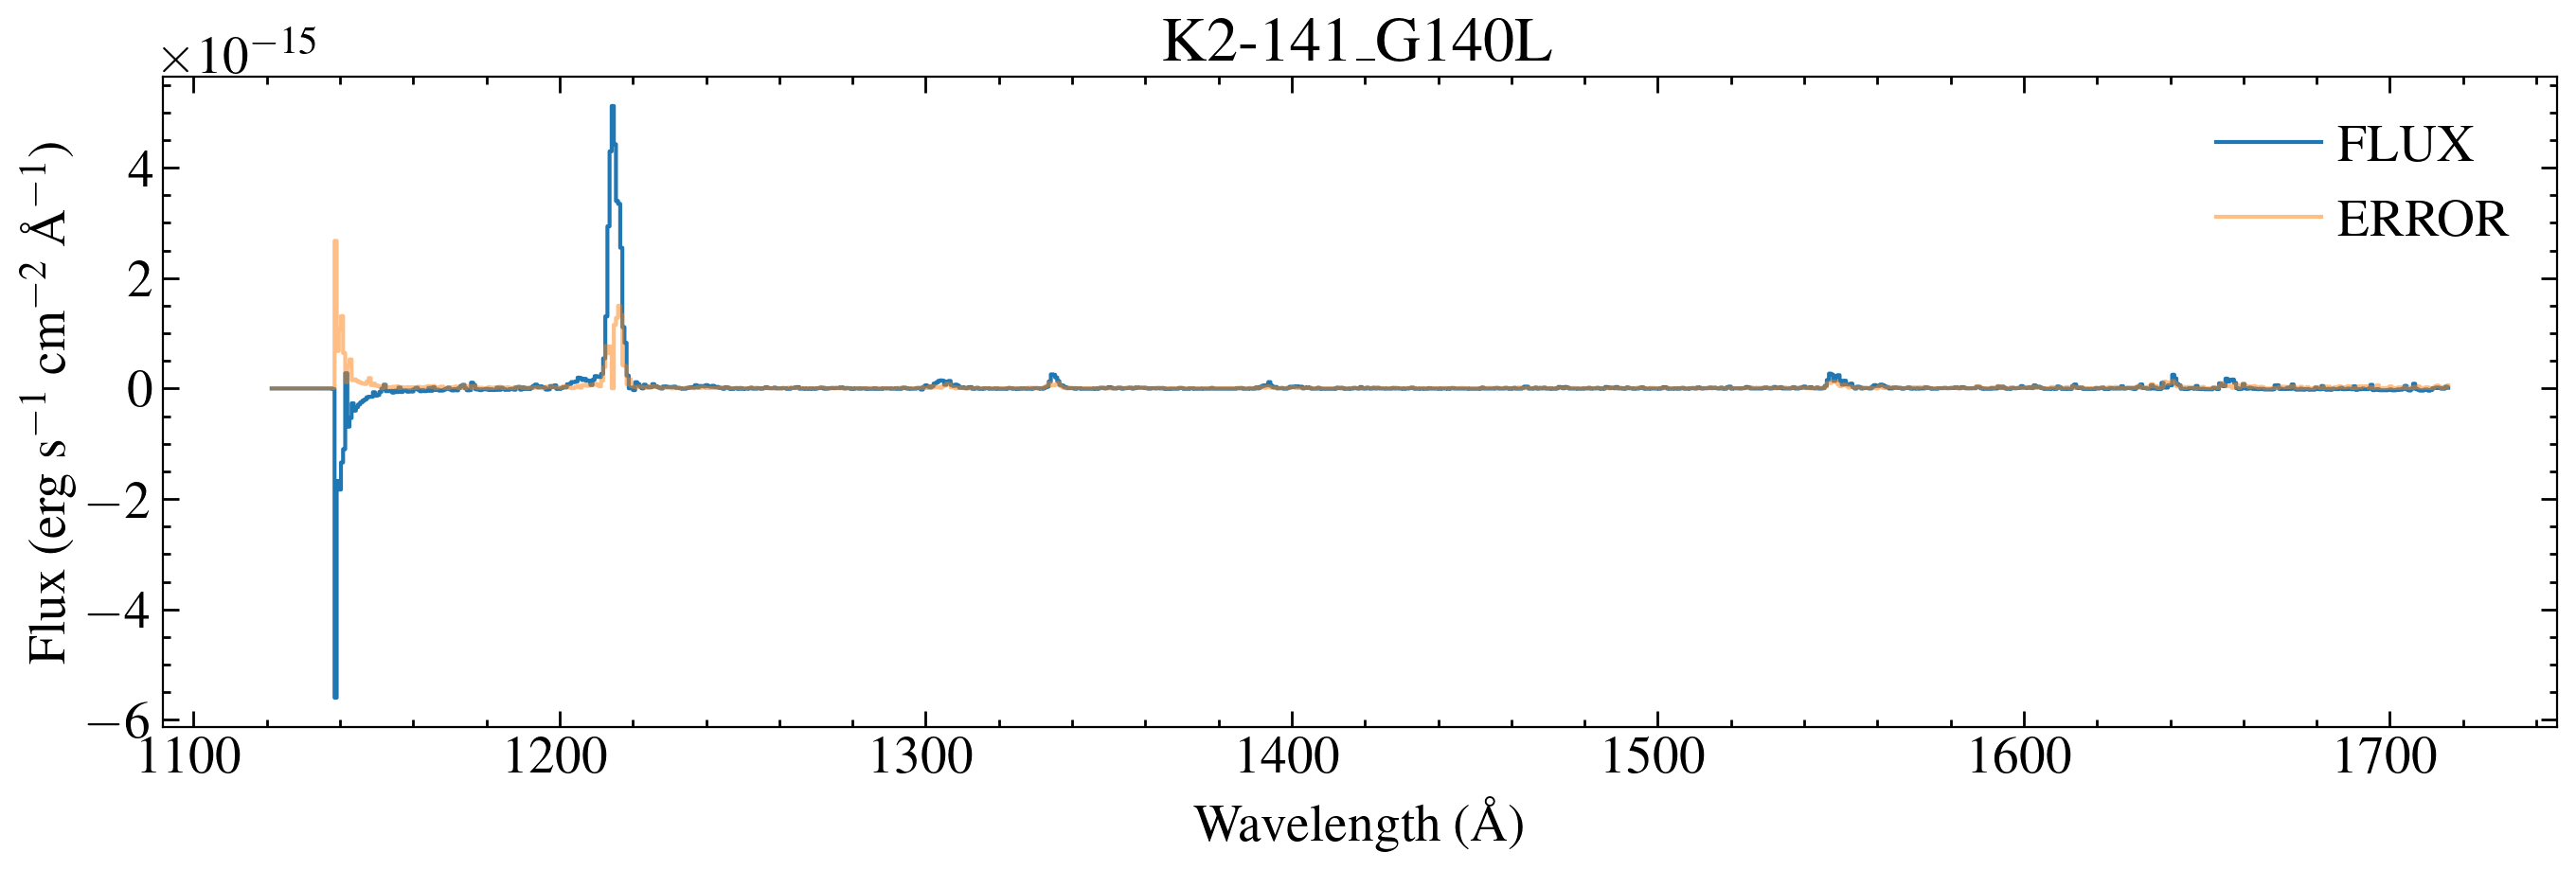

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g140l_v1_component-spec.fits


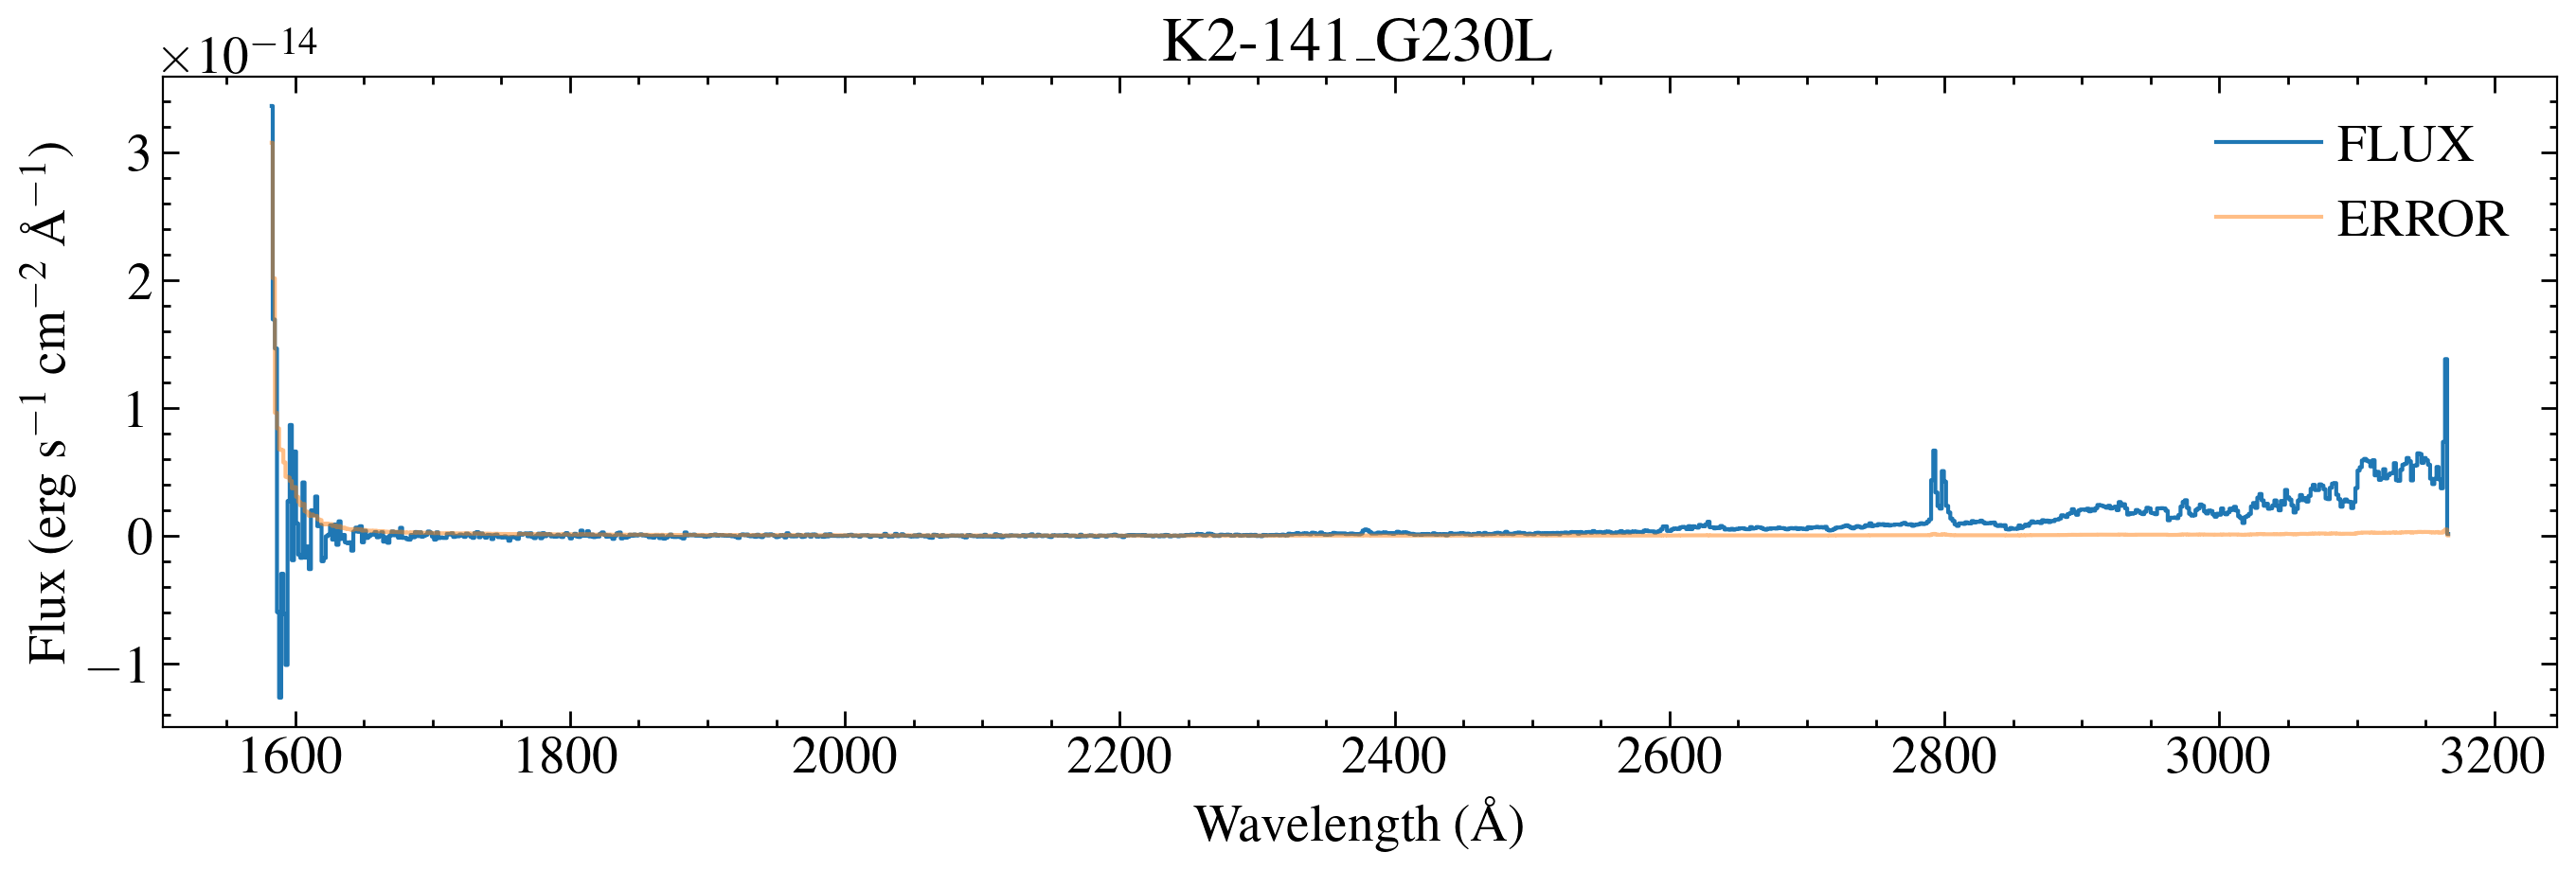

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g230l_v1_component-spec.fits


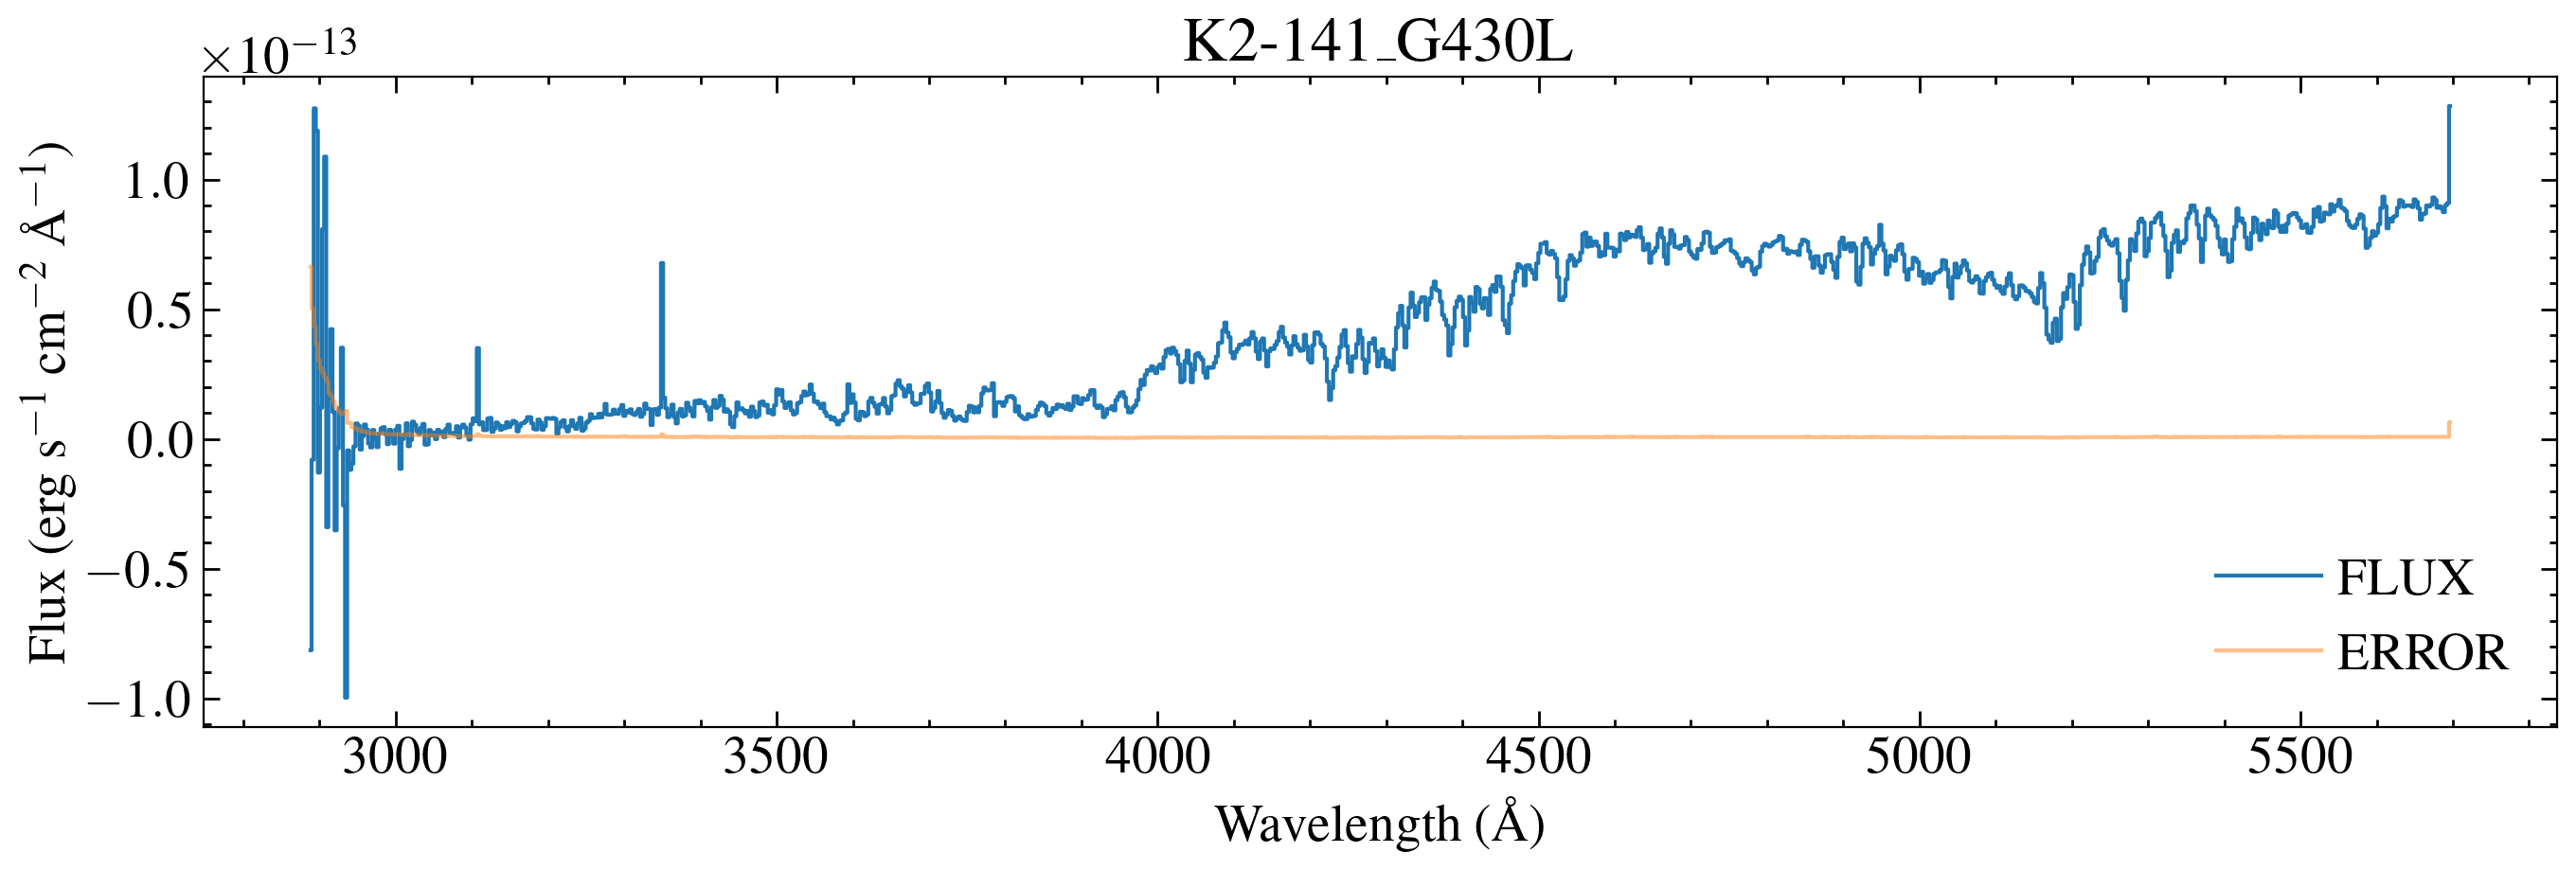

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits


In [16]:
# import prepare_stis
# x1dpath = path
# savepath = 'draft_hlsp/k2-141/'
# hlsp = 'meats_hlsp_info.csv'
# version = 1
# prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'K2-141')

In [17]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.708
teff = 4599
teff_e = 79

radius = 0.681
distance = 62.00

save_path = 'models/'
star = 'k2-141'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.62
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [29]:
hlsp_stis = glob.glob('draft_hlsp/k2-141/*stis*.fits')
hlsp_stis

['draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g140l_v1_component-spec.fits',
 'draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g230l_v1_component-spec.fits']

In [19]:
from dust_extinction.parameter_averages import F99


In [20]:
# swift
swiftpath = '/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/'
uvots = glob.glob('{}*phot.fits'.format(swiftpath))
uvots

['/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/k2-141_b_phot.fits',
 '/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/k2-141_uvm2_phot.fits',
 '/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/k2-141_u_phot.fits',
 '/media/david/2tb_ext_hd/hddata/meats/swift/k2-141/00097696002/uvot/products/k2-141_v_phot.fits']

In [28]:
# pmask = (pw > 2500) & (pw < 10000)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 1000)


# fig, ax = plt.subplots(figsize=(12,5))


# ext = F99(Rv=3.1)
# ebv = 0.14/3.1
# print(ebv)


# # for spec in hlsp_stis:
# spec = hlsp_stis[0]
# data = fits.getdata(spec, 1)
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

# mask = (w > 2950) & (w < 5690 )    
# w, f, e = w[mask], f[mask], e[mask]

# red = ext.extinguish(w*u.AA, Ebv = ebv)

# # ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
# ax.step(w, f/red, where='mid', label = 'G430L (E(B-V) = 0.04)',  alpha=0.8)



# spec = hlsp_stis[2]
# data = fits.getdata(spec, 1)
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

# mask = (w > 2000) & (w < 3000 )    
# w, f, e = w[mask], f[mask], e[mask]

# red = ext.extinguish(w*u.AA, Ebv = ebv)

# # ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
# ax.step(w, f/red, where='mid', label = 'G230L (E(B-V) = 0.04)',  alpha=0.8)

  
# ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5, label = 'PHX')

# ax.legend(frameon=True)

# ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
# ax.set_xlabel('Wavelength (\AA)')


# gaia = Table.read('misc_data/k2-141_gaia.vot')
# mask = gaia['type'] == 'XP'
# gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
# # mask = (gw > 3000) #& (gw < 1000)
# # gw, gf = gw[mask], gf[mask]

# gaia_red = ext.extinguish(gw*u.AA, Ebv = ebv)
# ax.plot(gw, gf/gaia_red, label='Gaia XP (E(B-V) = 0.04)')

# # ax.plot(gw, gf, label='Gaia XP')
# phot = Table.read('misc_data/k2-141_phot.vot')



# mask = (~phot['sed_eflux'].mask) & (phot['sed_eflux'] > 0) 



# phot_w = (phot['sed_freq'][mask]).to(u.AA,  equivalencies=u.spectral())
# phot_f = (phot['sed_flux'][mask]).to(u.erg/u.s/u.cm**2/u.AA,  equivalencies=u.spectral_density(phot_w))
# phot_e =np.array(phot['sed_eflux'][mask])
# phot_e = ((phot_e/phot['sed_flux'][mask]).value)*phot_f.value

# mask = phot_f.value/phot_e > 10
# # print(phot_e)
# # print(phot_e)
# ax.errorbar(phot_w[mask], phot_f[mask].value, yerr=phot_e[mask], ls='none', marker='o', ms=5)


# swift_ws = dict(U=3467.05, UVM2=2246.43, B=4349.56)

# # for uvot in uvots:
# #     data = fits.getdata(uvot, 1)[0]
# #     band = data['FILTER']
# #     ax.errorbar(swift_ws[band], data['FLUX_AA'], data['FLUX_AA_ERR'], marker='o', markeredgecolor='k', ls='none', c='C6')

# #uves useless
# # uves_path = '/media/david/2tb_ext_hd/hddata/meats/misc_data/k2-141/'
# # uves_specs = glob.glob('{}*ADP*.fits'.format(uves_path))
# # for spec in uves_specs:
# #     data = fits.getdata(spec, 1)[0]
# #     flux = convolve(data['FLUX'], Box1DKernel(500)) 
# #     ax.plot(data['WAVE'], flux*1e-15)



# ax.set_xlim(2001, 9999)
# ax.set_yscale('log')
# ax.set_ylim(1e-16)
# fig.tight_layout()




Ugh oh. There were guide star issues in the first observation, are G140ls different?

/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20020_x1d.fits
[92.17609]
/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20030_x1d.fits
/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo42010_x1d.fits
[130.67415]
/media/david/2tb_ext_hd/hddata/meats/hst/k2-141/oeoo20040_sx1.fits


(-5e-17, 5e-16)

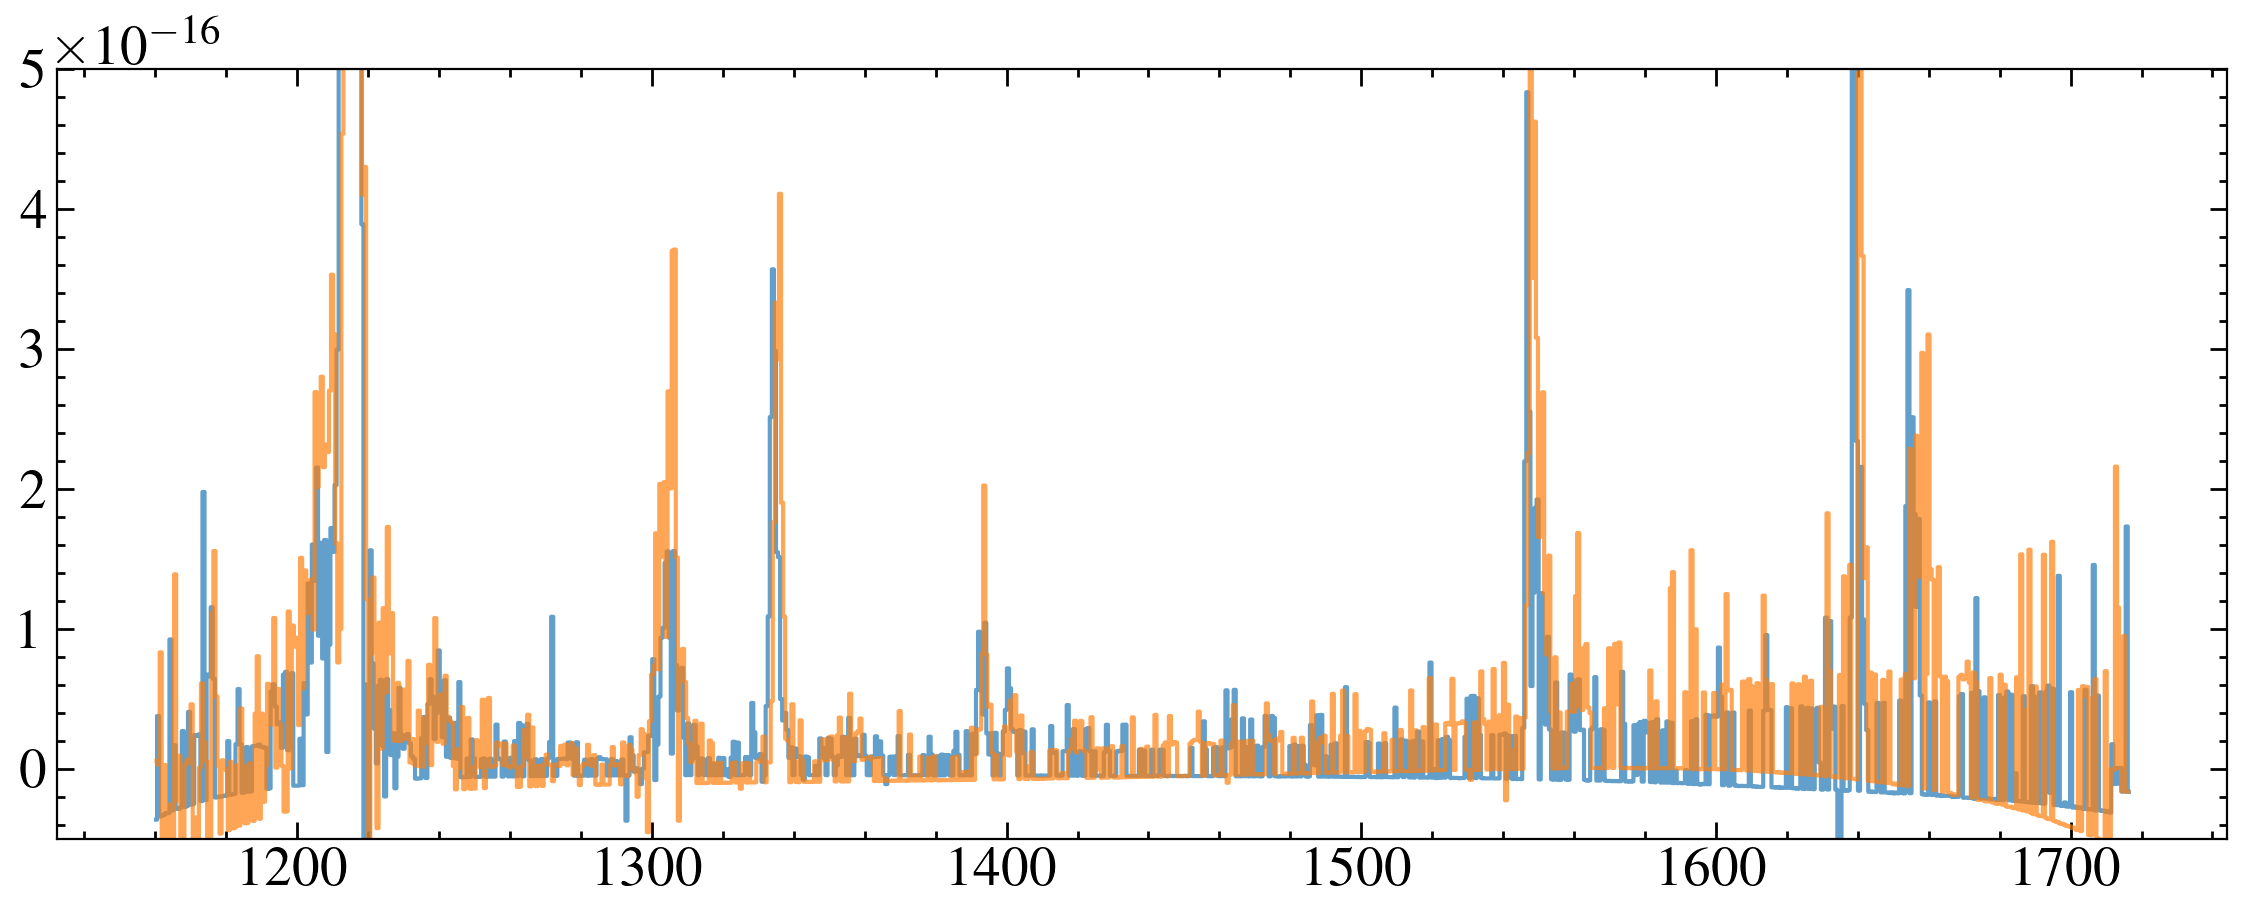

In [22]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G140L':
    # print(fits.getheader(x, 0)['OPT_ELEM'])
        data = fits.getdata(x, 1)
        print(data['A2Center'])
        # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        for dt in data:
            w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
            if grating == 'G430L':
                mask = w > 3000
            else:
                mask = w > 1160
            
            w, f, e = w[mask], f[mask], e[mask]
            plt.step(w, f, where='mid', alpha=0.7)
            # plt.step(w, e, where='mid', c='C1')
            # plt.yscale('log')
        # plt.show()
    
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-17)
plt.ylim(-0.5e-16, 0.5e-15)

Already implemented the slitloss corrections,can play!

In [23]:
def slit_loss(wavelength_array, offset, coeff_table_path = 'slit_loss_coeffs.txt'):
    """
    Implements the slit loss correction from https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/stis/documentation/instrument-science-reports/_documents/2022_05.pdf Section 3.2
    """
    coeff_tab = Table.read(coeff_table_path, format='ascii.basic') 
    row = coeff_tab[coeff_tab['Offset(′′)'] == offset]
    # print(row)
    q = (wavelength_array/ 4500)**0.5
    D_lambda = row['a'][0] + row['b'][0]*q + row['c'][0]*q**2 + row['d'][0]*q**3 + row['e'][0]*q**4 + row['f'][0]*q**5 + row['g'][0]*q**6 
    return D_lambda


offtab = Table.read('slit_loss_coeffs.txt', format='ascii.basic')
# offtab

print(offtab['Offset(′′)'])

Offset(′′)
----------
     -0.06
     -0.05
     -0.04
     -0.03
     -0.02
     -0.01
      0.01
      0.02
      0.03
      0.04
      0.05
      0.06


0.04516129032258065
uvm2 1.6652403519276457
gNUV 1.3869627830575395


(1e-16, 1.3743165544788283e-14)

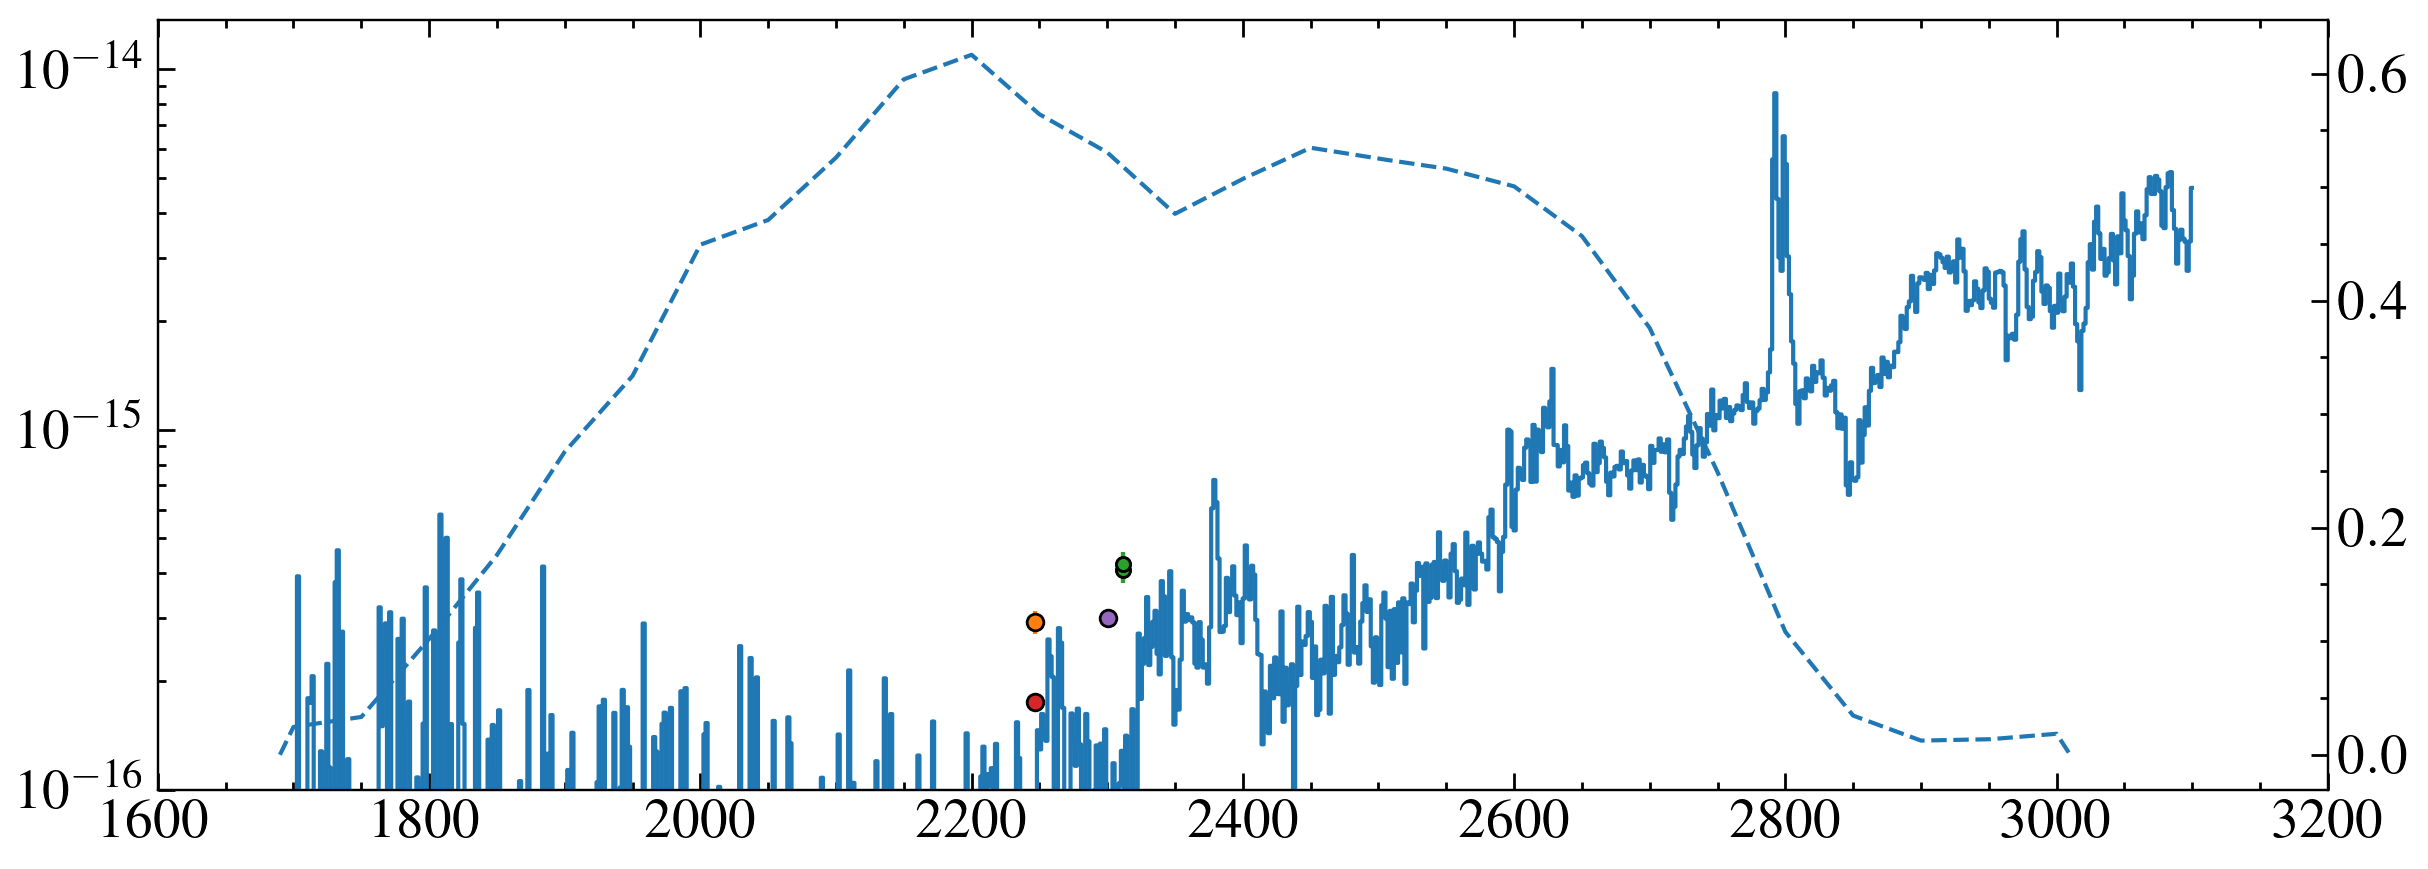

In [61]:
def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    flux = np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapz(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 
        
offsets = offtab['Offset(′′)']

pmask = (pw > 2500) & (pw < 10000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)


# fig, ax = plt.subplots(figsize=(12,5))


ext = F99(Rv=3.1)
ebv = 0.14/3.1
print(ebv)


# for spec in hlsp_stis:
# spec = hlsp_stis[0]
# data = fits.getdata(spec, 1)
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

# mask = (w > 2950) & (w < 5690 )    
# w, f, e = w[mask], f[mask], e[mask]

# red = ext.extinguish(w*u.AA, Ebv = ebv)

# # ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
# ax.step(w, f/red, where='mid', label = 'G430L (E(B-V) = 0.04)', alpha=1, zorder=100)
# ax.step(w, (f/red)*1.4, where='mid', label = 'G430L (E(B-V) = 0.04)', alpha=1, zorder=100)

# # for off in offsets:
#     # dlambda = slit_loss(w, off)
#     # ax.step(w, (f/dlambda)/red, where='mid',  alpha=0.5)
    

# # spec = hlsp_stis[2]
# # data = fits.getdata(spec, 1)
# # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

# # mask = (w > 2000) & (w < 3000 )    
# # w, f, e = w[mask], f[mask], e[mask]

# # red = ext.extinguish(w*u.AA, Ebv = ebv)

# # ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
# # ax.step(w, f/red, where='mid', label = 'G230L (E(B-V) = 0.04)')

  
# ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5, label = 'PHX')

# ax.legend(frameon=True)

# ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
# ax.set_xlabel('Wavelength (\AA)')


# gaia = Table.read('misc_data/k2-141_gaia.vot')
# mask = gaia['type'] == 'XP'
# gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
# # mask = (gw > 3000) #& (gw < 1000)
# # gw, gf = gw[mask], gf[mask]

# gaia_red = ext.extinguish(gw*u.AA, Ebv = ebv)
# ax.plot(gw, gf/gaia_red, label='Gaia XP (E(B-V) = 0.04)')

# # ax.plot(gw, gf, label='Gaia XP')
# phot = Table.read('misc_data/k2-141_phot.vot')



# mask = (~phot['sed_eflux'].mask) & (phot['sed_eflux'] > 0) 



# phot_w = (phot['sed_freq'][mask]).to(u.AA,  equivalencies=u.spectral())
# phot_f = (phot['sed_flux'][mask]).to(u.erg/u.s/u.cm**2/u.AA,  equivalencies=u.spectral_density(phot_w))
# phot_e =np.array(phot['sed_eflux'][mask])
# phot_e = ((phot_e/phot['sed_flux'][mask]).value)*phot_f.value

# mask = phot_f.value/phot_e > 10
# # print(phot_e)
# # print(phot_e)
# # ax.errorbar(phot_w[mask], phot_f[mask].value, yerr=phot_e[mask], ls='none', marker='o', ms=5)


# swift_ws = dict(U=3467.05, UVM2=2246.43, B=4349.56, V=5425.33)

# for uvot in uvots:
#     data = fits.getdata(uvot, 1)[0]
#     band = data['FILTER']
#     if band in ['U', 'B', 'V']:
#         ax.errorbar(swift_ws[band], data['FLUX_AA'], yerr=data['FLUX_AA_ERR_SYS'], marker='o', markeredgecolor='k', ls='none', c='C6')
#         bpw, bpf = np.loadtxt('/home/david/work/filters/uvot/Swift_UVOT.{}.dat'.format(band), unpack=True)
#         uflux, uerr = make_phot(bpw, bpf, w, f/red, e/red)
#         ax.errorbar(swift_ws[band], uflux, yerr=uerr, marker='o', markeredgecolor='k', ls='none')
#         print(band, data['FLUX_AA']/uflux)

# #uves useless
# # uves_path = '/media/david/2tb_ext_hd/hddata/meats/misc_data/k2-141/'
# # uves_specs = glob.glob('{}*ADP*.fits'.format(uves_path))
# # for spec in uves_specs:
# #     data = fits.getdata(spec, 1)[0]
# #     flux = convolve(data['FLUX'], Box1DKernel(500)) 
# #     ax.plot(data['WAVE'], flux*1e-15)



# ax.set_xlim(3000, 7000)
# ax.set_yscale('log')
# ax.set_ylim(1e-14)
# fig.tight_layout()

fig, ax = plt.subplots()

spec = hlsp_stis[1]
data = fits.getdata(spec, 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = (w > 1700) & (w < 3100 )    
w, f, e = w[mask], f[mask], e[mask]

red = ext.extinguish(w*u.AA, Ebv = ebv)

# ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
ax.step(w, f/red, where='mid', label = 'G230L (E(B-V) = 0.04)',  alpha=1, zorder=100)
# for off in offsets:
#     dlambda = slit_loss(w, off)
#     ax.step(w, (f/dlambda)/red, where='mid',  alpha=0.5)


for uvot in uvots:
    data = fits.getdata(uvot, 1)[0]
    band = data['FILTER']
    if band == 'UVM2':
        ax.errorbar(swift_ws[band], data['FLUX_AA'], yerr=data['FLUX_AA_ERR'], marker='o', markeredgecolor='k', ls='none')
        uvm2flux =  data['FLUX_AA']

mask = (phot_f.value/phot_e > 10) & (phot_w.value < 3000)  
# print(phot_e)
# print(phot_e)
ax.errorbar(phot_w[mask], phot_f[mask].value, yerr=phot_e[mask], ls='none', marker='o', ms=5, markeredgecolor='k')
nflux = np.mean(phot_f[mask]).value

axr=ax.twinx()

bpw, bpf = np.loadtxt('/home/david/work/filters/uvot/Swift_UVOT.UVM2.dat', unpack=True)
# axr.plot(bpw, bpf, ls='--')
uflux, uerr = make_phot(bpw, bpf, w, f/red, e/red)
ax.errorbar(swift_ws['UVM2'], uflux, yerr=uerr, marker='o', markeredgecolor='k', ls='none')
print('uvm2', uvm2flux/uflux)
uvm2_ratio = uvm2flux/uflux

bpw, bpf = np.loadtxt('/home/david/work/filters/galex/GALEX_GALEX.NUV.dat', unpack=True)
axr.plot(bpw, bpf, ls='--')

uflux, uerr = make_phot(bpw, bpf, w, f/red, e/red)
ax.errorbar(2300.78, uflux, yerr=uerr, marker='o', markeredgecolor='k', ls='none')
print('gNUV', nflux/uflux)


ax.set_xlim(1600, 3200)
ax.set_yscale('log')
ax.set_ylim(1e-16)




Decision: Scale to the photometry in the NUV, don't use the Optical. Need to deal with the FUV. Changed mind, optical with the swift scaling looks much better

[92.17609]
958
[130.67415]
957


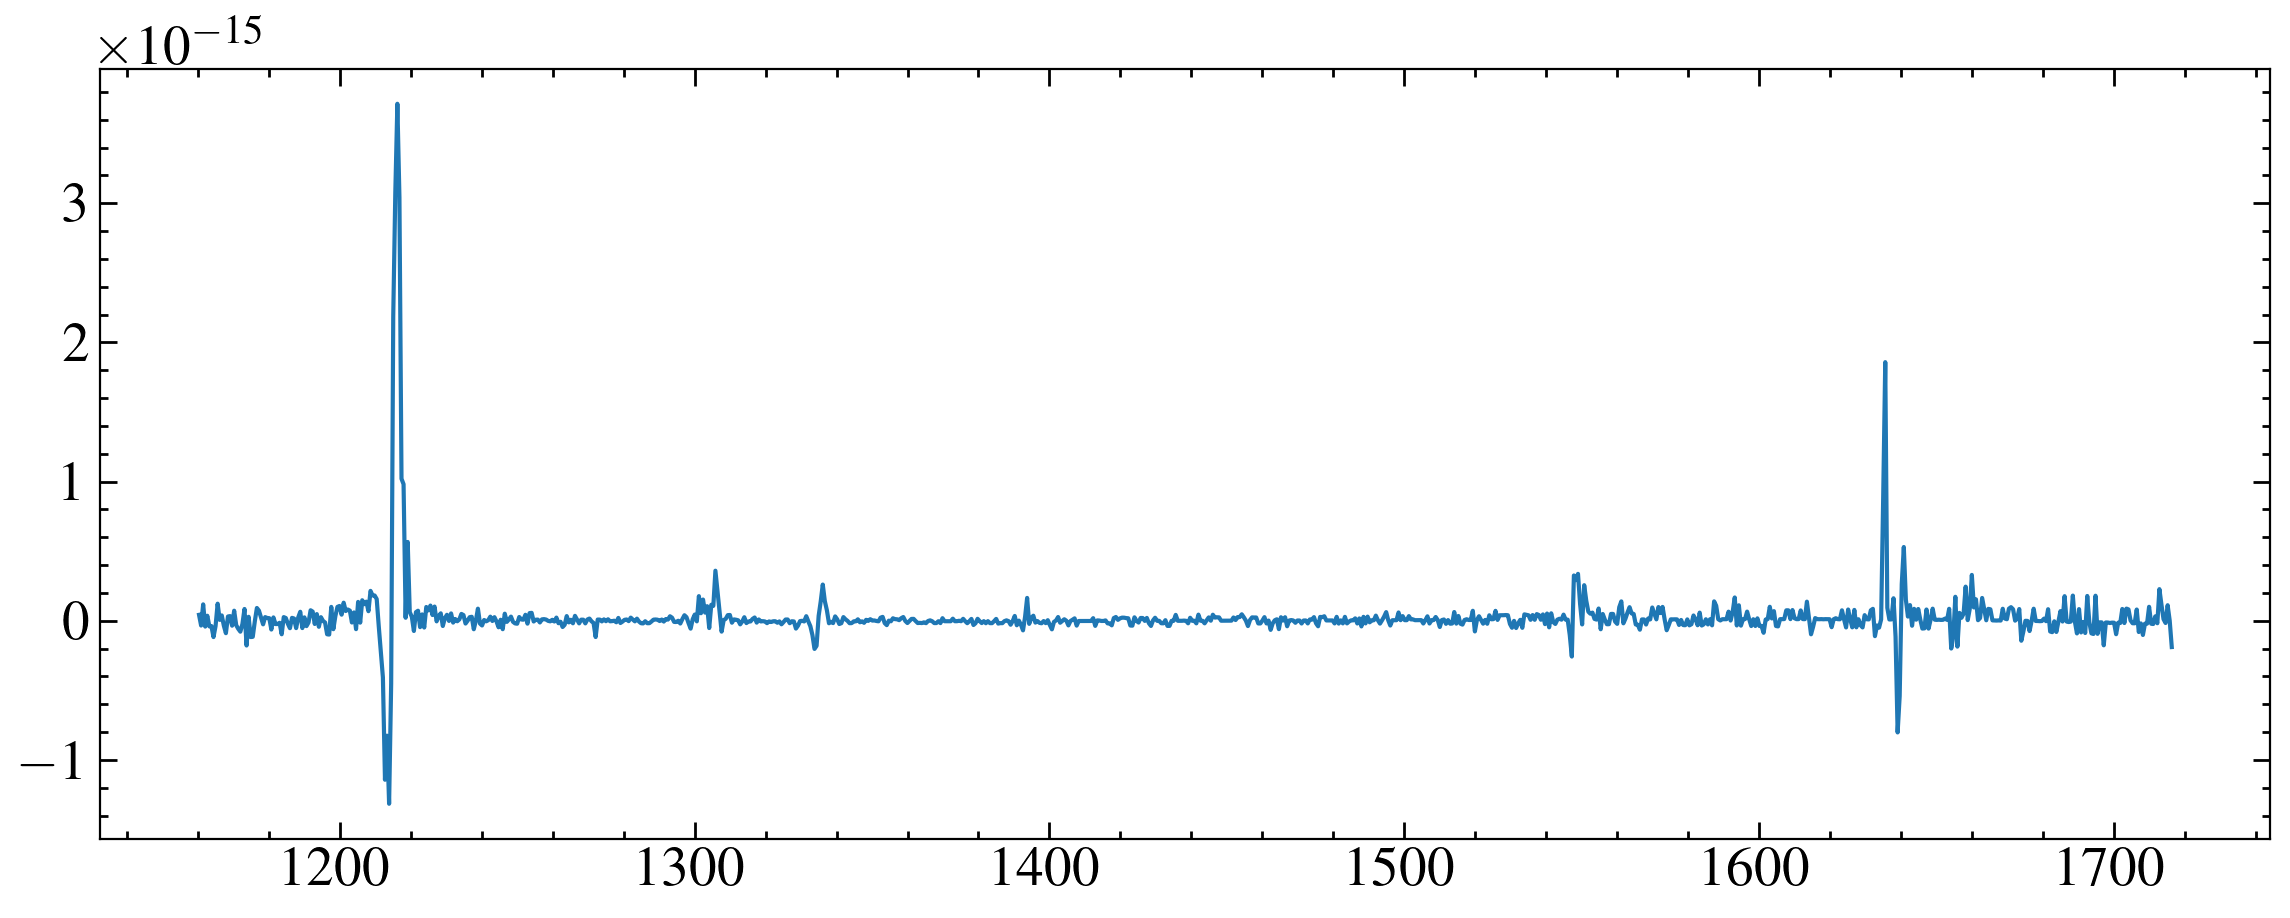

In [25]:
ws = []
fs = []
es = []

for x in x1ds:
    # print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G140L':
    # print(fits.getheader(x, 0)['OPT_ELEM'])
        data = fits.getdata(x, 1)
        print(data['A2Center'])
        # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        for dt in data:
            w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
            if grating == 'G430L':
                mask = w > 3000
            else:
                mask = w > 1160
            
            w, f, e = w[mask], f[mask], e[mask]
            # plt.step(w, f, where='mid', alpha=0.7)
            ws.append(w)
            print(len(w))
            fs.append(f)
            es.append(e)
            # plt.step(w, e, where='mid', c='C1')
            # plt.yscale('log')
        # plt.show()
    
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-17)
# plt.ylim(-0.5e-16, 0.5e-15)
diff = np.diff([fs[0][:-1], fs[1]], axis=0)[0]
fig, ax = plt.subplots()


ax.plot(ws[1], diff)

Only use the most recent FUV

/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]


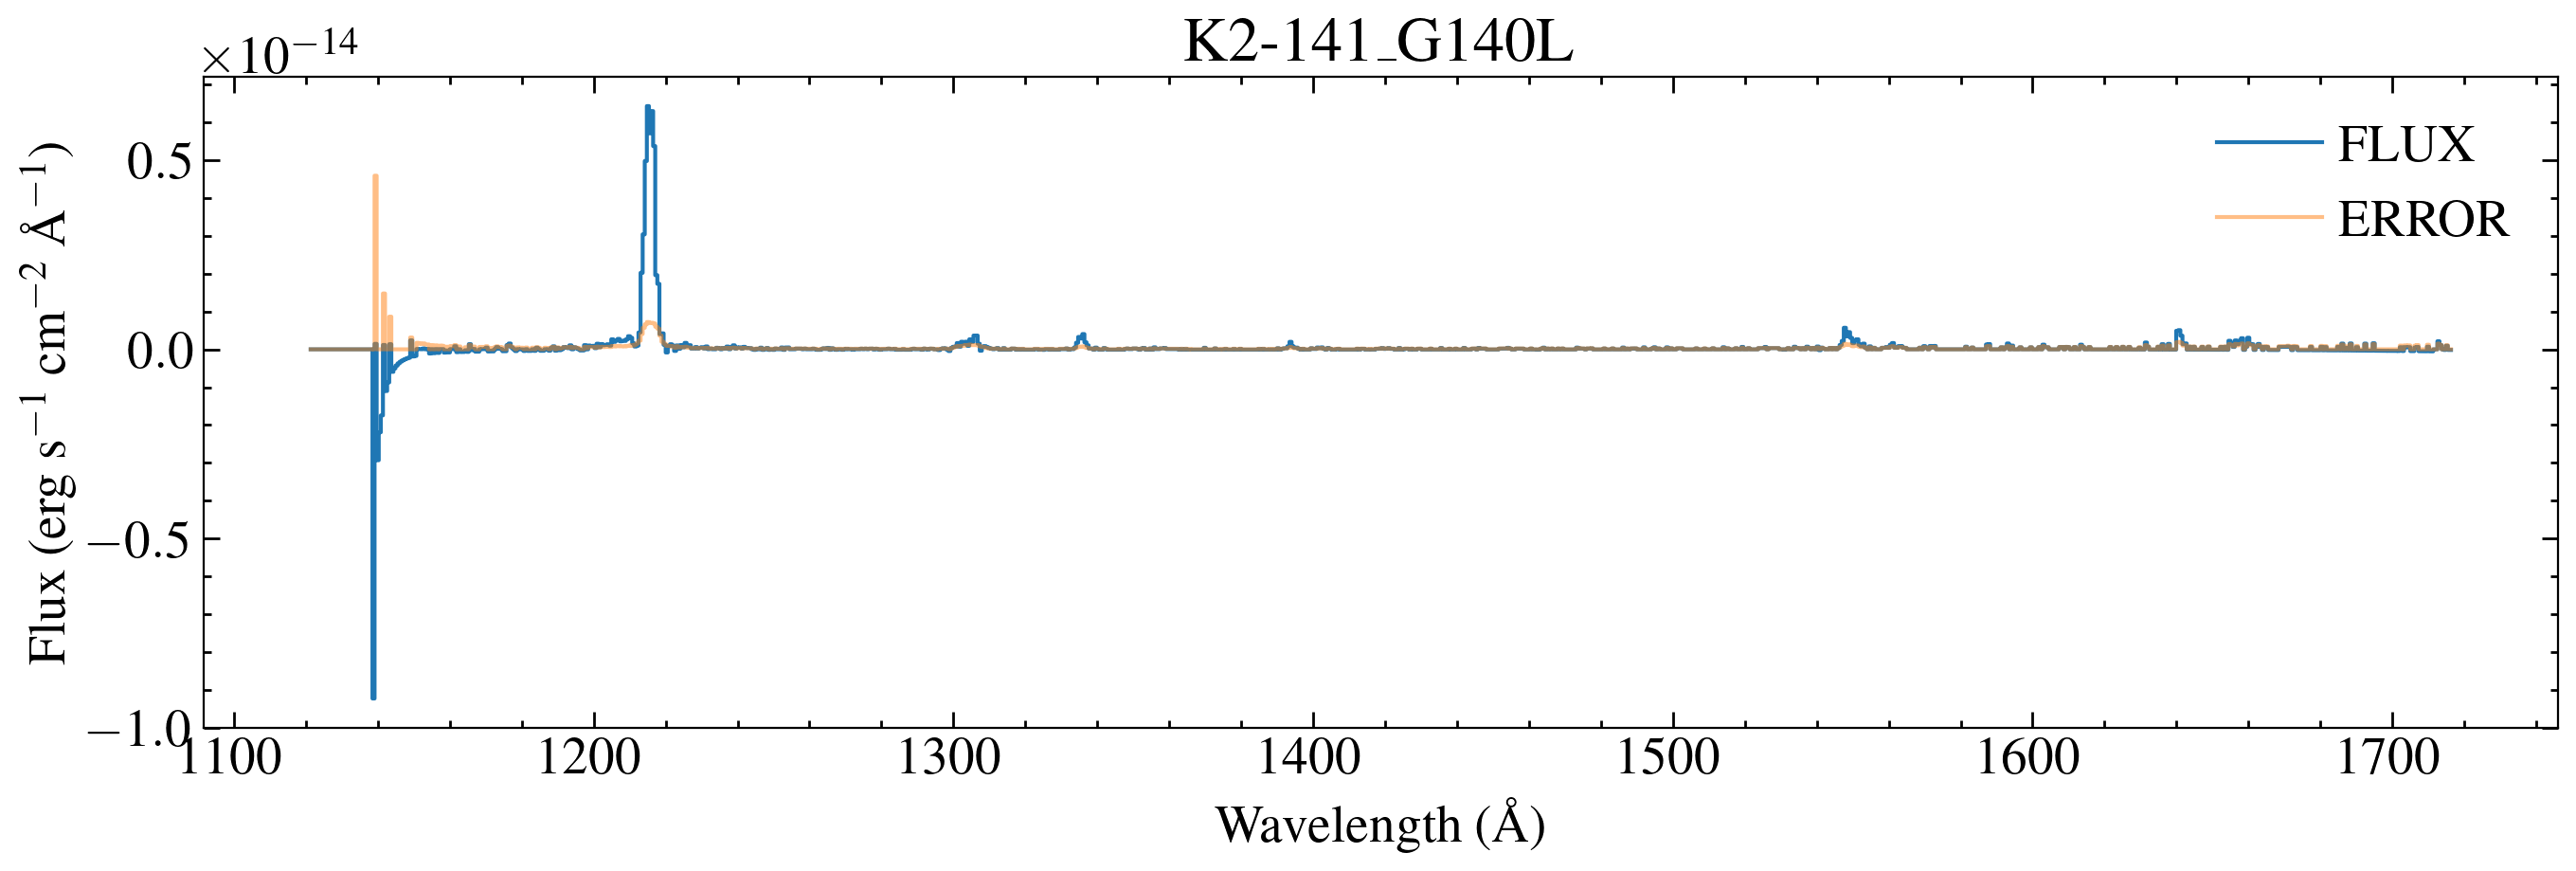

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g140l_v1_component-spec.fits


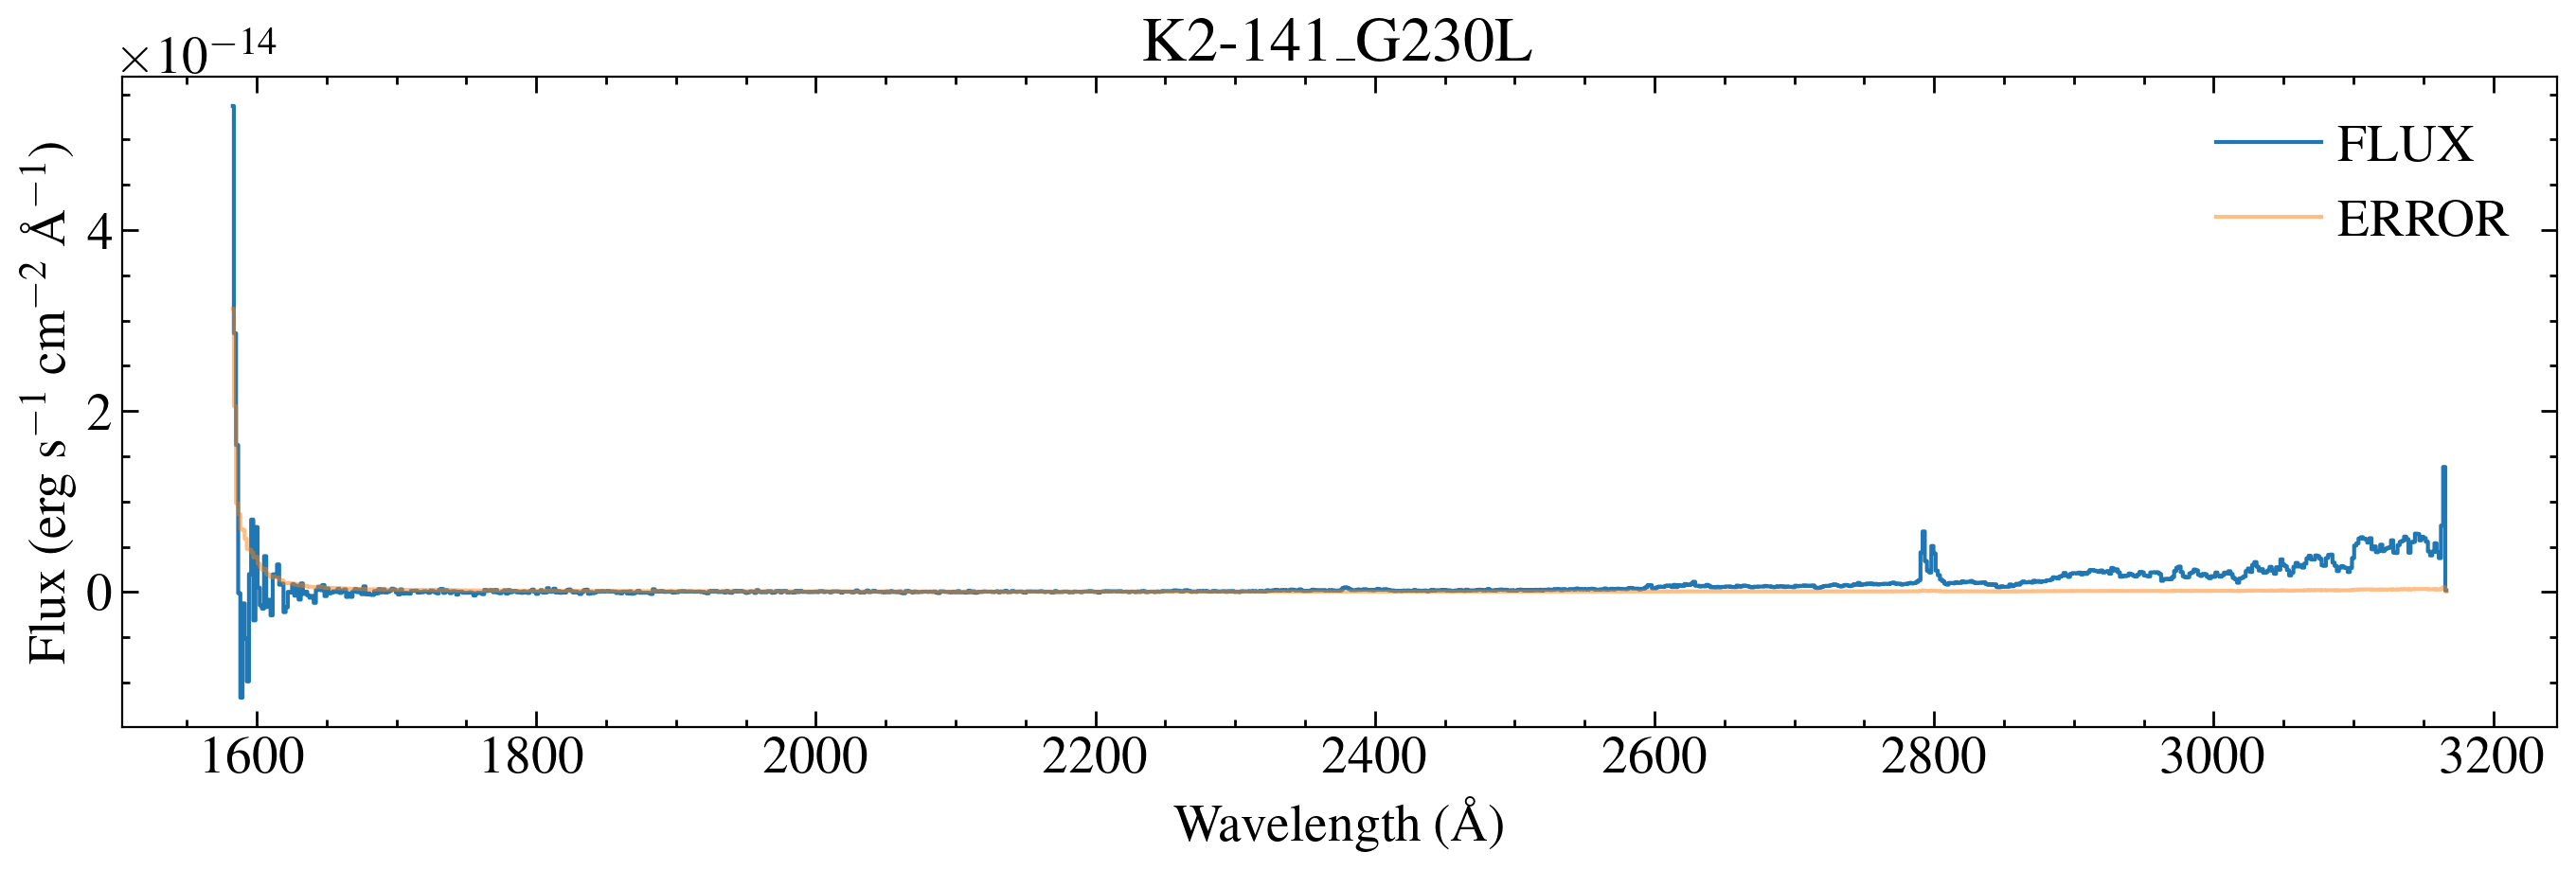

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g230l_v1_component-spec.fits


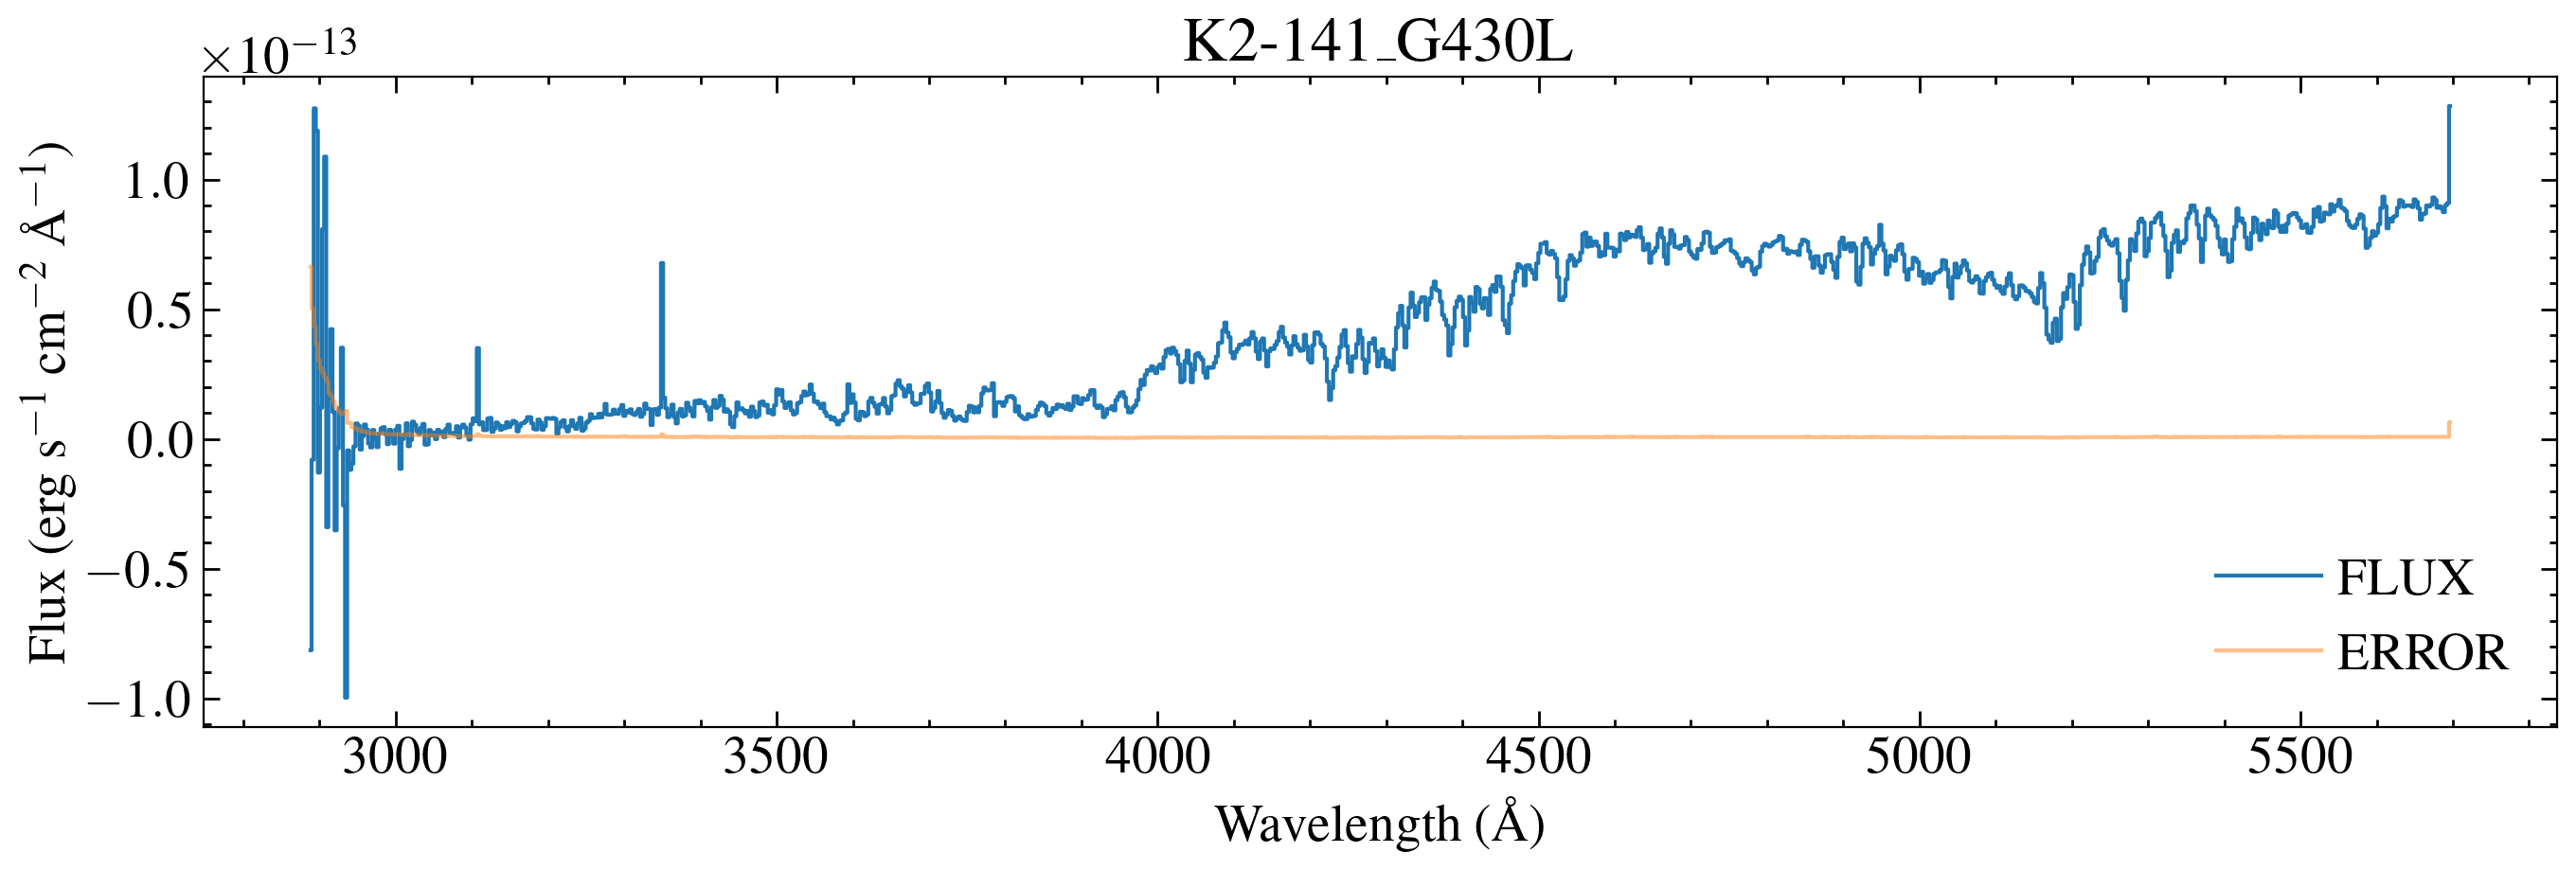

Spectrum saved as hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits


In [76]:
import prepare_stis
x1dpath = path
savepath = 'draft_hlsp/k2-141/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath+'use_spectra/', version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'K2-141')

In [77]:
g430l = fits.open('draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits')
g430l[0].header['NORMFAC'] = uvm2_ratio
g430l.writeto('draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits', overwrite=True)

In [95]:
g230l = fits.open('draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g230l_v1_component-spec.fits')
g230l[0].header['NORMFAC'] = uvm2_ratio
g230l.writeto('draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g230l_v1_component-spec.fits', overwrite=True)

In [33]:
import prepare_model
hdr = fits.getheader('draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g140l_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)
#PHX
prepare_model.make_model_spectrum('models/k2-141_phoenix_interpolated.ecsv', 1, sed_data, savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')


Spectrum saved as hlsp_muscles_model_phx_k2-141_na_v1_component-spec.fits


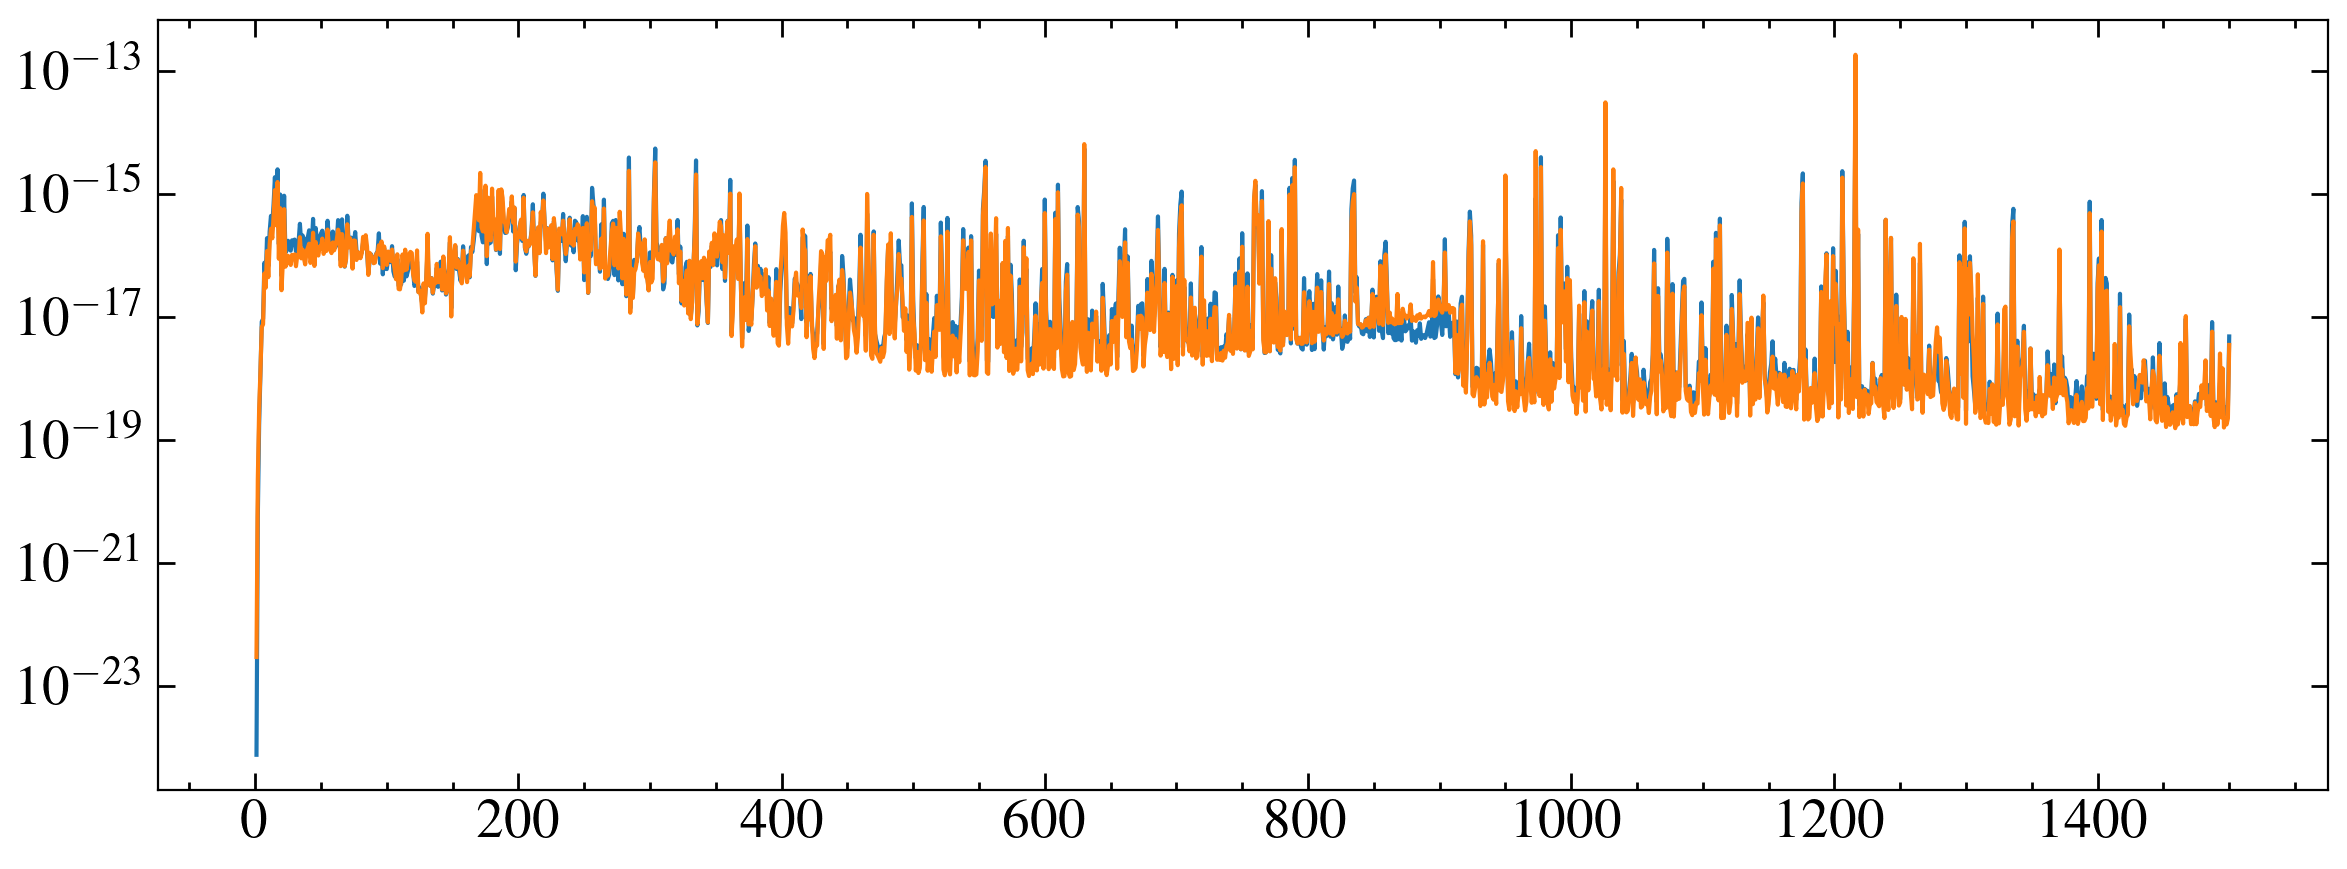

In [35]:
# dem
dempath = '/media/david/2tb_ext_hd/hddata/meats/dems/k2-141/spectrum_K2-141_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
demtab.write('models/k2-141_dem.ecsv', overwrite=True)



In [36]:
prepare_model.make_model_spectrum('models/k2-141_dem.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='dem')

Spectrum saved as hlsp_muscles_model_dem_k2-141_na_v1_component-spec.fits


In [40]:
xpath = '/media/david/2tb_ext_hd/hddata/meats/xmm/k2-141/K2-141.fits'
hdul = fits.open(xpath)
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'K2-141  '                                                            
HIERARCH Instrument = 'EPIC    '                                                

In [41]:
hdr.append(('mos1_FILTER', 'Medium'))
hdr.append(('mos2_FILTER', 'Medium'))
hdr.append(('pn_FILTER', 'Thin1'))
hdr.append(('pn_DURATION', 37900))
hdr.append(('pn_DATE-OBS', '2015-12-09 14:54:11'))
hdr.append(('pn_DATE-END','2015-12-10 01:25:51' ))
hdr.append(('OBS_ID', '0762260301'))
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'K2-141  '                                                            
HIERARCH Instrument = 'EPIC    '                                                
HIERARCH mos1_FILTER = 'Medium  '                                               
HIERARCH mos2_FILTER = 'Medium  '                                               
HIERARCH pn_FILTER = 'Thin1   '                                                 
HIERARCH pn_DURATION = 37900                                                    
HIERARCH pn_DATE-OBS = '2015-12-09 14:54:11'                                    
HIERARCH pn_DATE-END = '2015-12-10 01:25:51'                                    
OBS_ID  = '0762260301'      

In [42]:
hdul.writeto('/media/david/2tb_ext_hd/hddata/meats/xmm/k2-141/K2-141_djw.fits', overwrite=True)


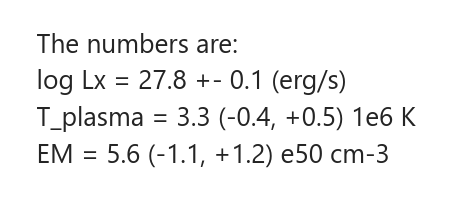

In [47]:
distance

<Quantity 62. pc3>

In [52]:
print((3.3e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))
print((2.9e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))
print((3.8e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))


# distance = 1000/0.43
# print(distance)
# that's not right
distance = 62 *u.pc
lx = (10**27.8)*u.erg/u.s
lx_e = [0.0, (10**27.7), (10**27.9)]*u.erg/u.s
for e in lx_e:
    fx = (lx) / (4*np.pi*(distance.to(u.cm))**2)
    fxe = (e) / (4*np.pi*(distance.to(u.cm))**2)
    # print()
    print(abs(fx-fxe)*1e14)

0.2843719976507909 keV
0.24990266460221017 keV
0.3274586639615168 keV
1.3718469641970594 erg / (s cm2)
0.28215018681454795 erg / (s cm2)
0.3552060401232934 erg / (s cm2)


In [53]:
import prepare_xmm

xmm_path = '/media/david/2tb_ext_hd/hddata/meats/xmm/k2-141/K2-141_djw.fits'

hlsp = dict(Table.read('meats_hlsp_info.csv'))
# hlsp = np.genfromtxt('meats_hlsp_info.csv', delimiter=',', dtype=None, names=True)
# xmm_path = xpath
version = 1

prepare_xmm.make_xmm_spectra(xmm_path, savepath, version, hlsp, apec_repo='models/', make_apec=True, save_ecsv=False, save_fits=True)

Spectrum saved as hlsp_muscles_xmm_epic_k2-141_na_v1_component-spec.fits


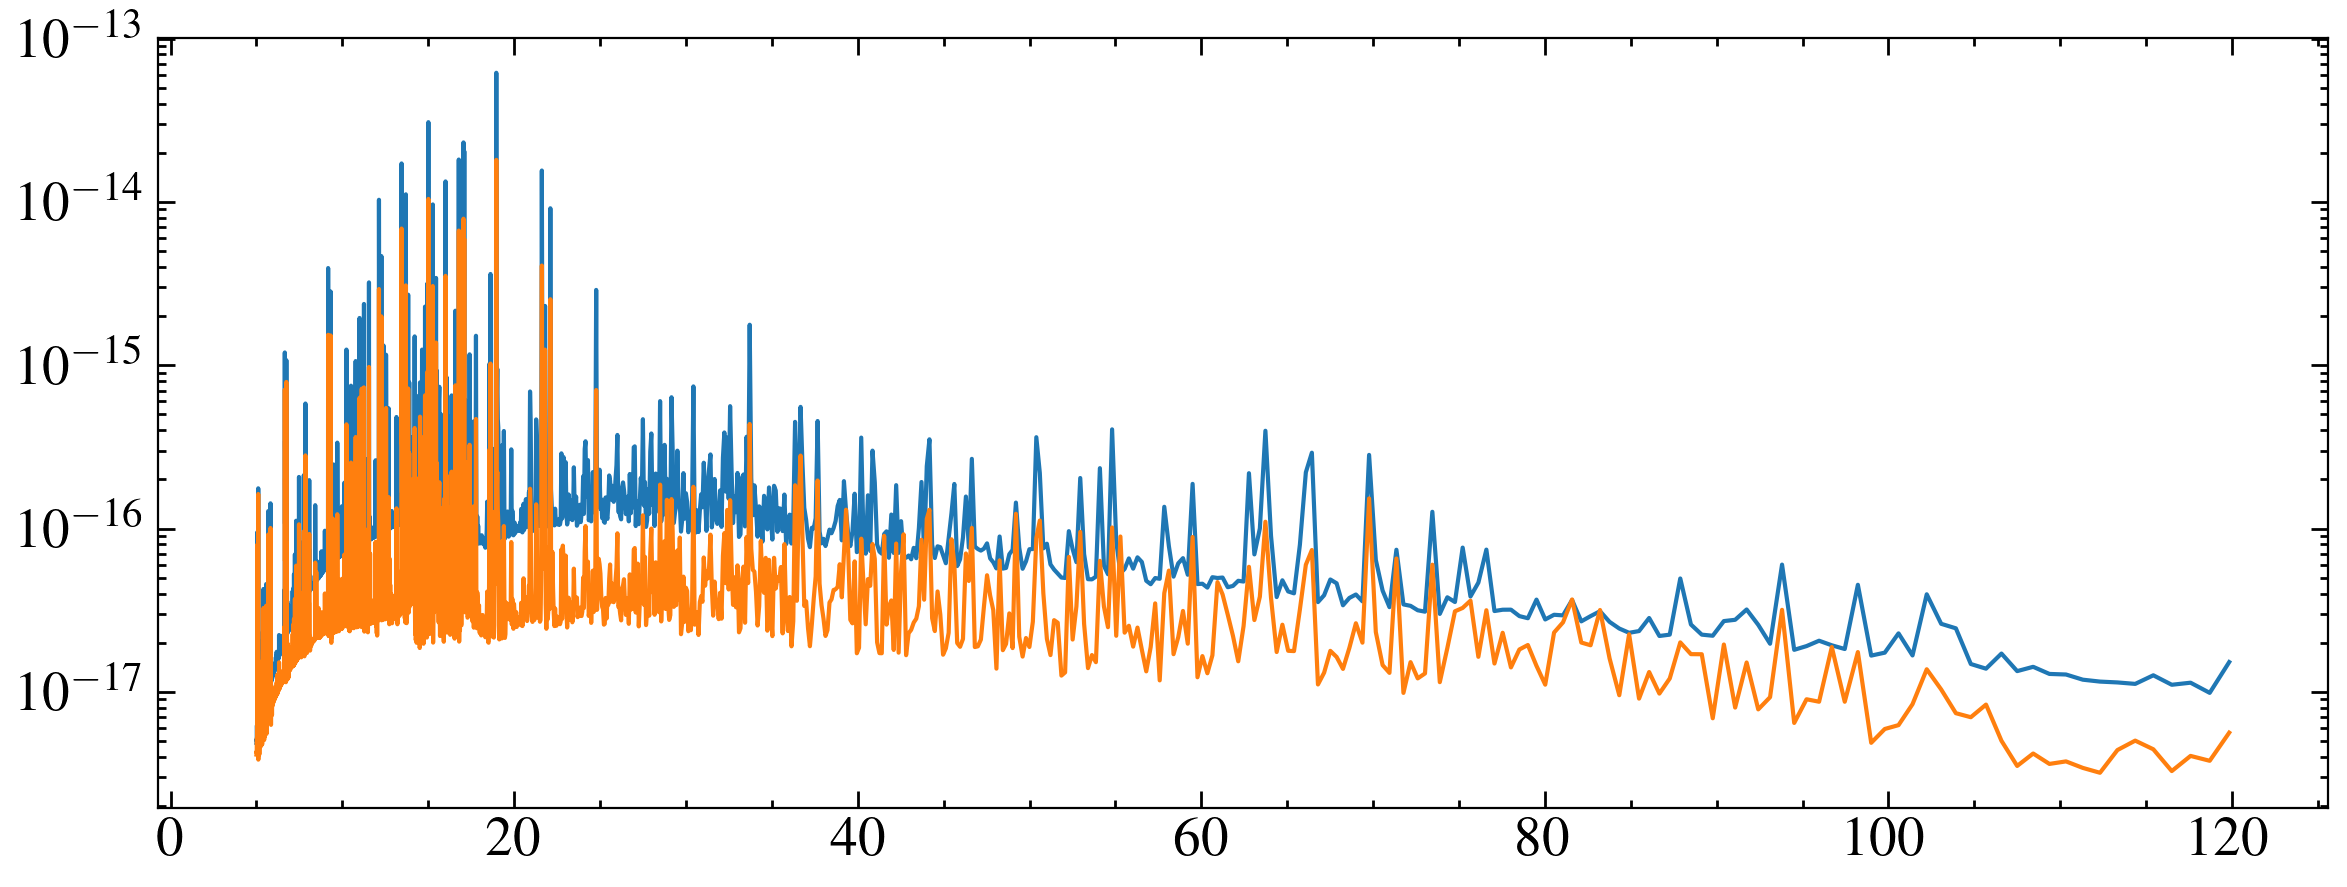

In [59]:
xray = Table.read('models/K2-141_apec_errs.ecsv')
plt.plot(xray['WAVELENGTH'], xray['FLUX'])
plt.plot(xray['WAVELENGTH'], xray['ERROR'])
plt.yscale('log')

In [60]:
prepare_model.make_model_spectrum('models/K2-141_apec_errs.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='apec')

Spectrum saved as hlsp_muscles_model_apec_k2-141_na_v1_component-spec.fits


In [56]:
#lya while we wait...
lyapath = '/media/david/2tb_ext_hd/hddata/meats/lya/k2-141/K2141_LyA_estimate.txt'

prepare_model.make_model_spectrum(lyapath, 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='lya')


Spectrum saved as hlsp_muscles_model_lya_k2-141_na_v1_component-spec.fits


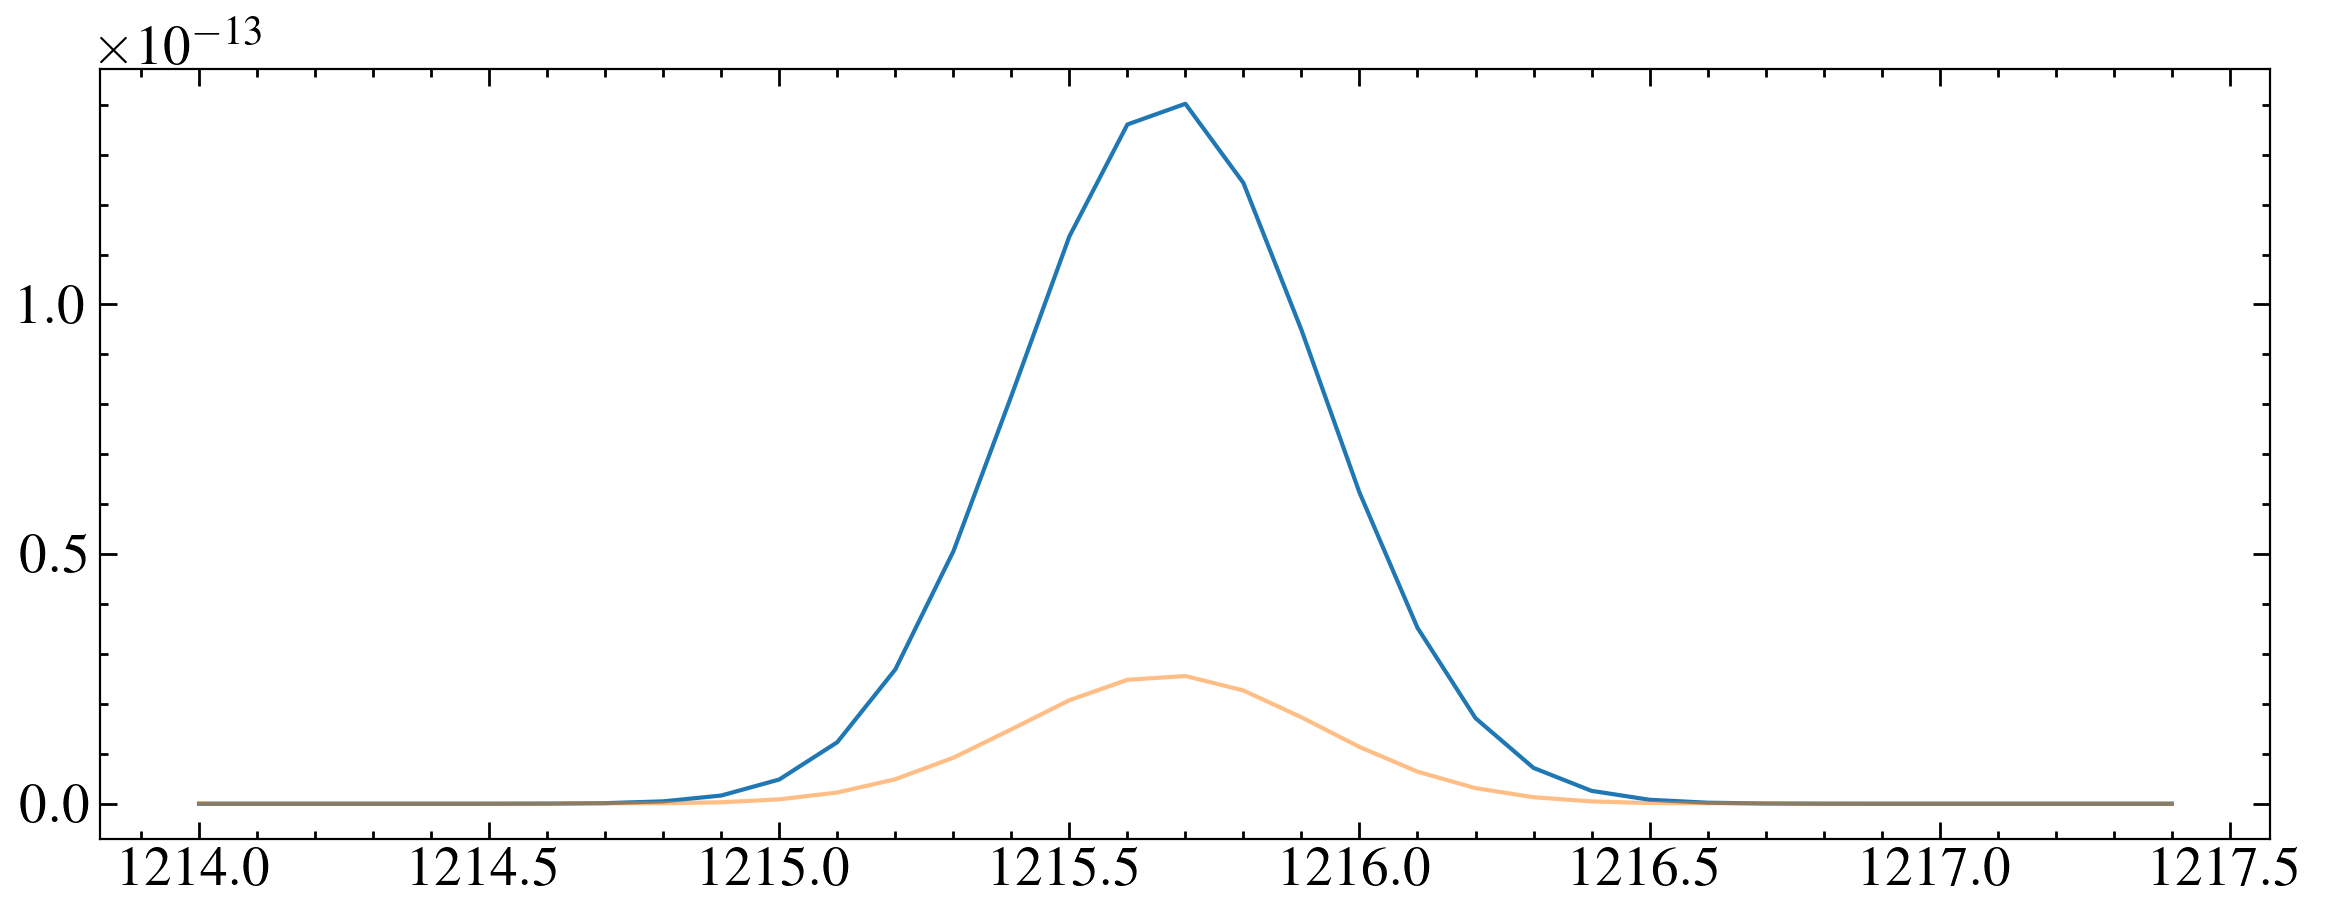

In [58]:
lya = fits.getdata('draft_hlsp/k2-141/hlsp_muscles_model_lya_k2-141_na_v1_component-spec.fits', 1)
fig, ax = plt.subplots()
ax.plot(lya['WAVELENGTH'], lya['FLUX'])
ax.plot(lya['WAVELENGTH'], lya['ERROR'], alpha=0.5)
# ax.plot(lya['WAVELENGTH'], lya['FLUX']/lya['ERROR'])
# ax.set_yscale('log')

Check match between NUV and PHX, xmm negative values - remove negs already an option, good.

2

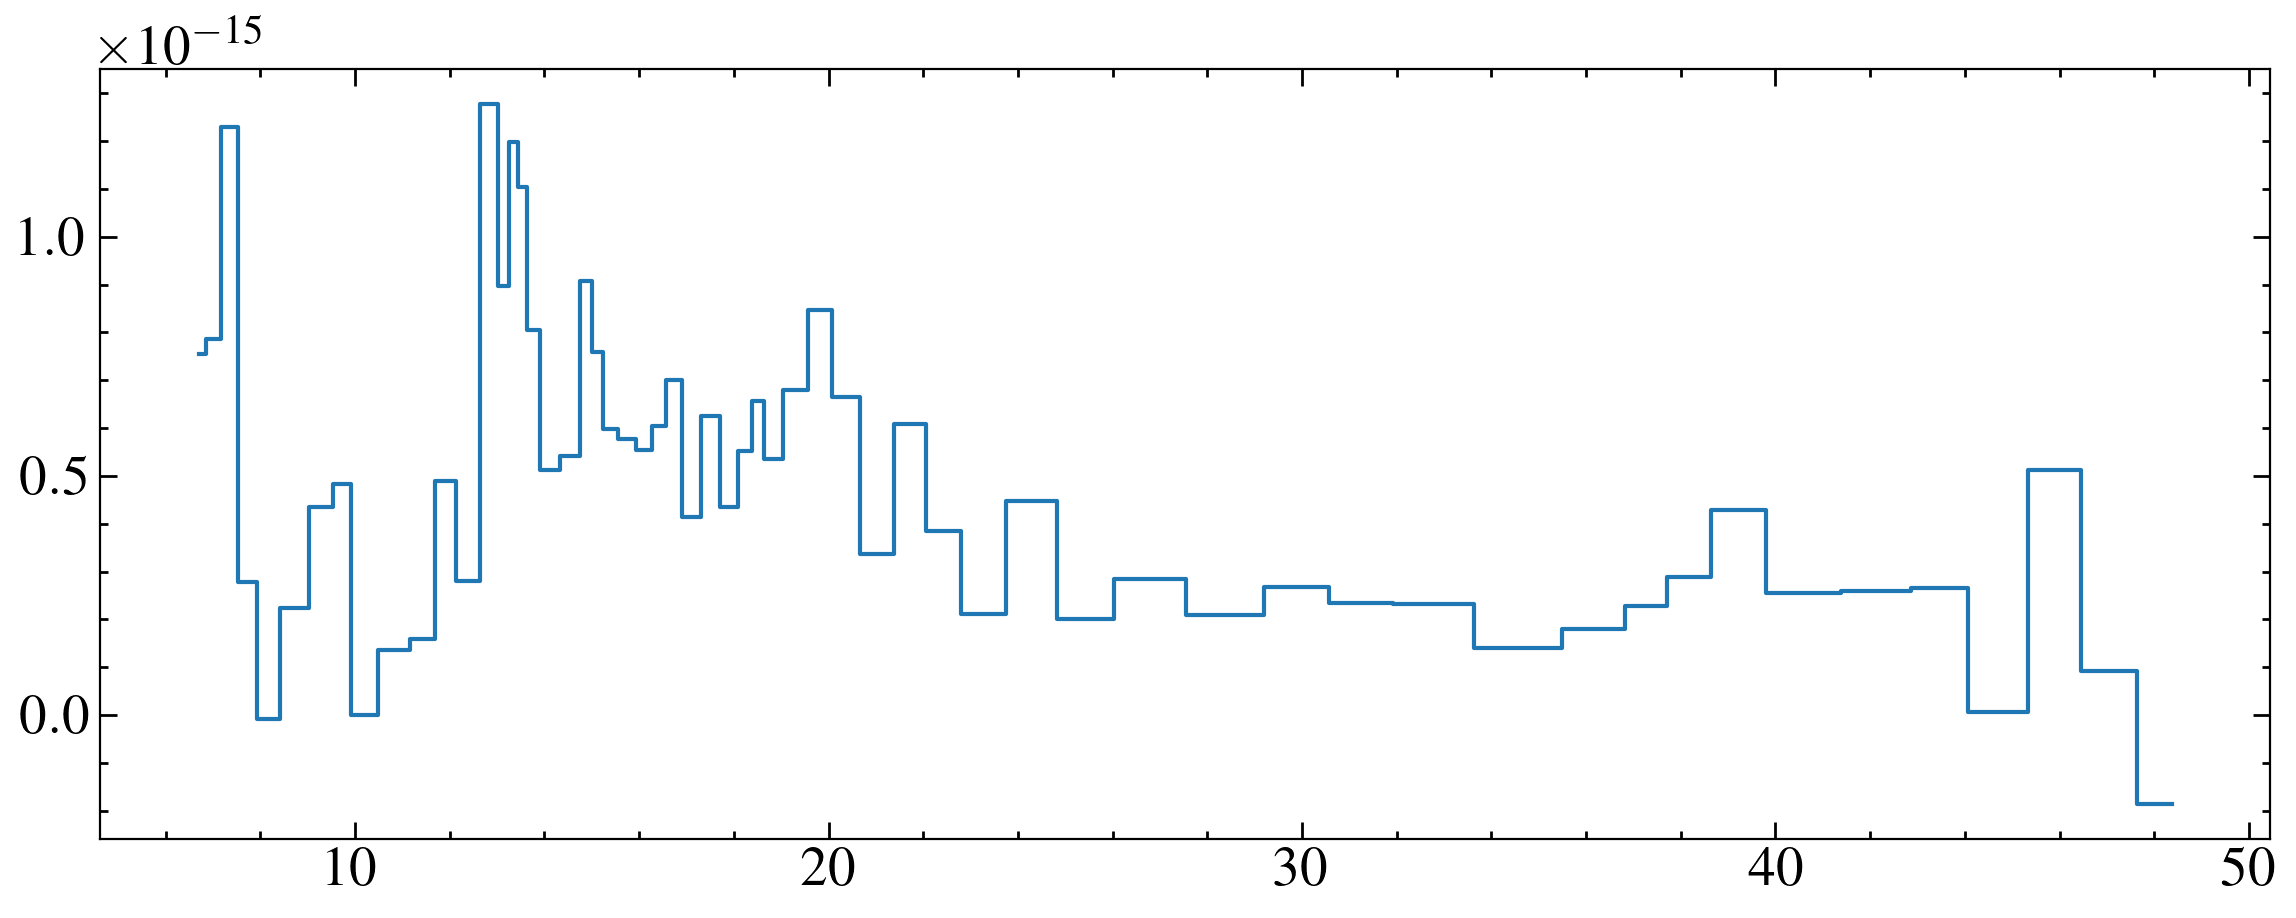

In [63]:
xdata = fits.getdata('draft_hlsp/k2-141/hlsp_muscles_xmm_epic_k2-141_na_v1_component-spec.fits', 1)
fig, ax = plt.subplots()
ax.step(xdata['WAVELENGTH'], xdata['FLUX'], where='mid')
len(xdata['FLUX'][xdata['FLUX'] <0])

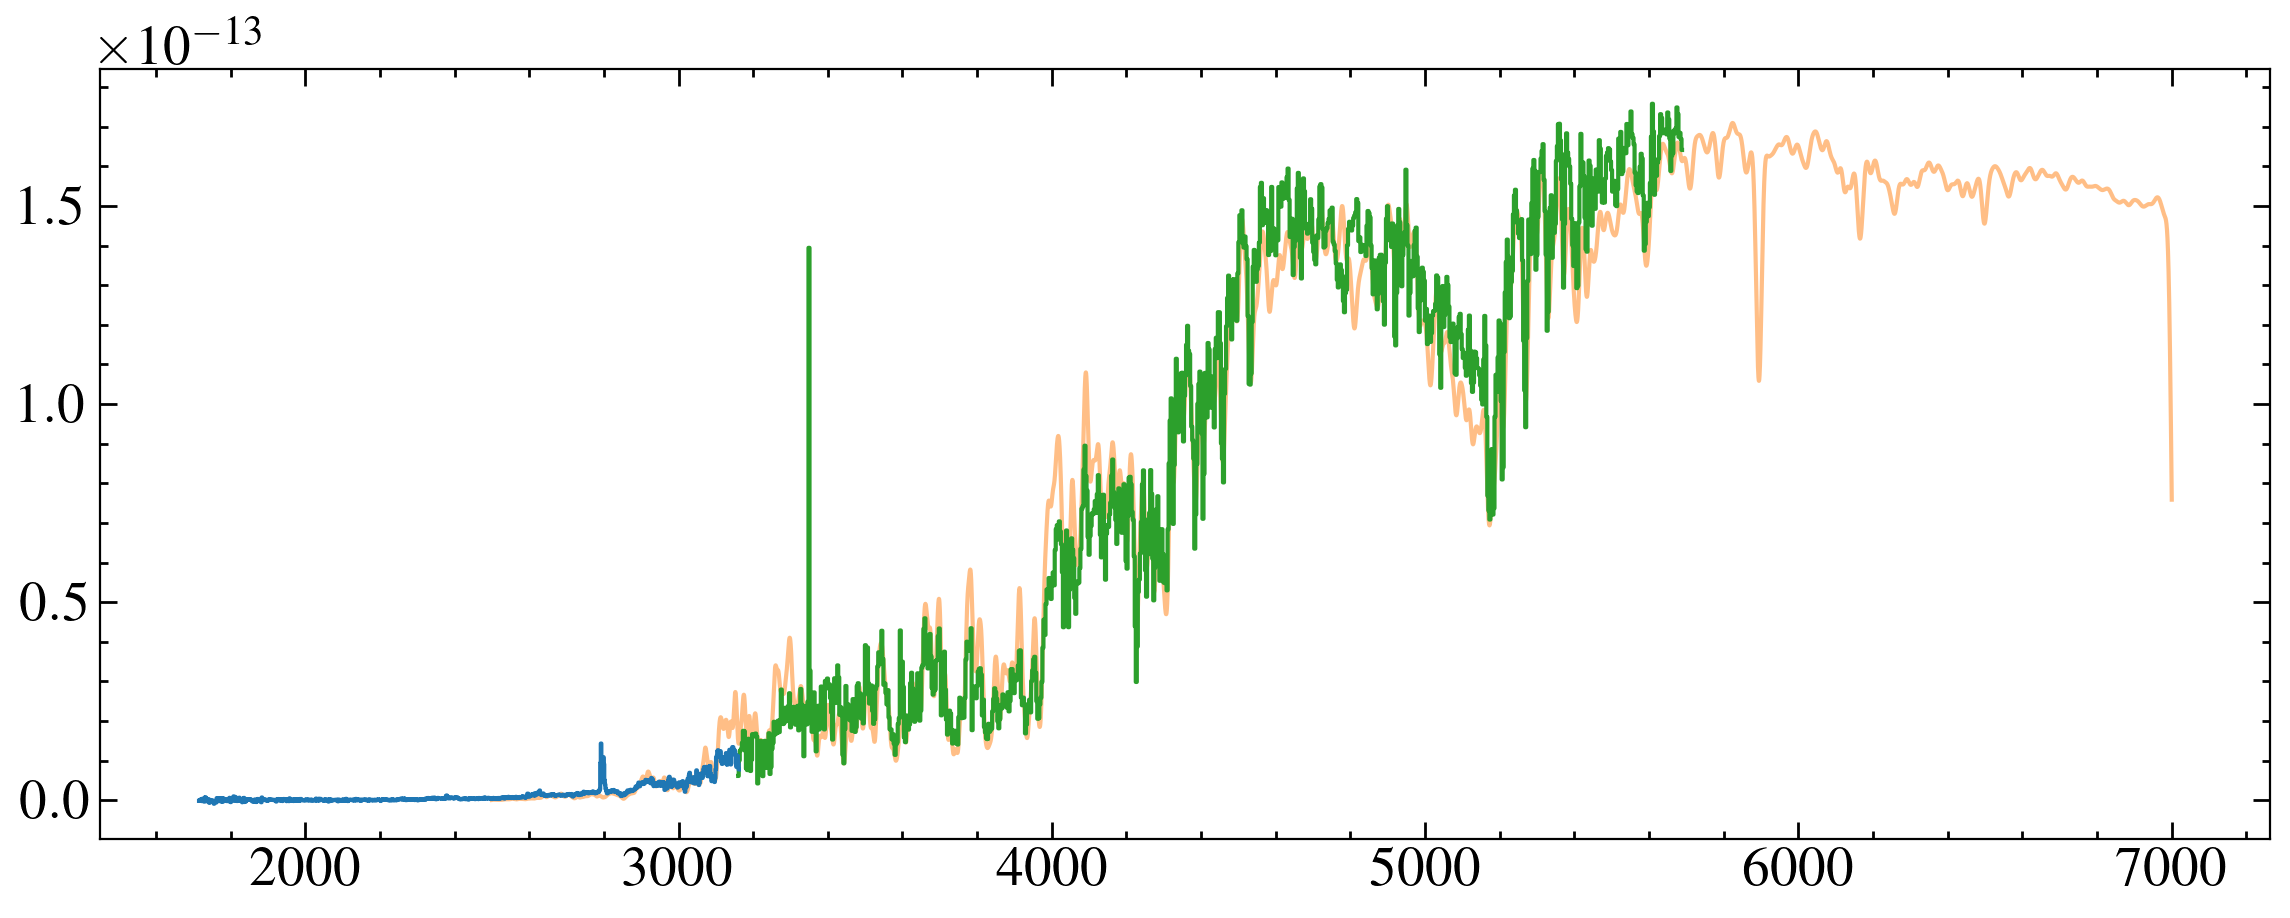

In [84]:
fig, ax = plt.subplots()

spec = hlsp_stis[1]
data = fits.getdata(spec, 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = (w > 1715) & (w < 3162 )    
w, f, e = w[mask], f[mask], e[mask]

red = ext.extinguish(w*u.AA, Ebv = ebv)

# ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
ax.step(w, (f/red)*uvm2_ratio, where='mid', label = 'G230L (E(B-V) = 0.04)',  alpha=1, zorder=100)

pmask = (pw > 2500) & (pw < 7000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)

ax.plot(pwi, pfi, alpha=0.5)

odata = fits.getdata(x1ds[3], 1)[0]
ow, of, oe= odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
mask = (ow > 3160) & (ow < 5690)
ow, of, oe=ow[mask], of[mask], oe[mask]
ored = ext.extinguish(ow*u.AA, Ebv = ebv)

ax.step(ow, (of/ored)*uvm2_ratio, where='mid')

# ax.set_yscale('log')

# ax.set_

Scale the g430l to the phx model around 5000, already got the scripts for that

6.132728817651107e-20
1.558452506608472


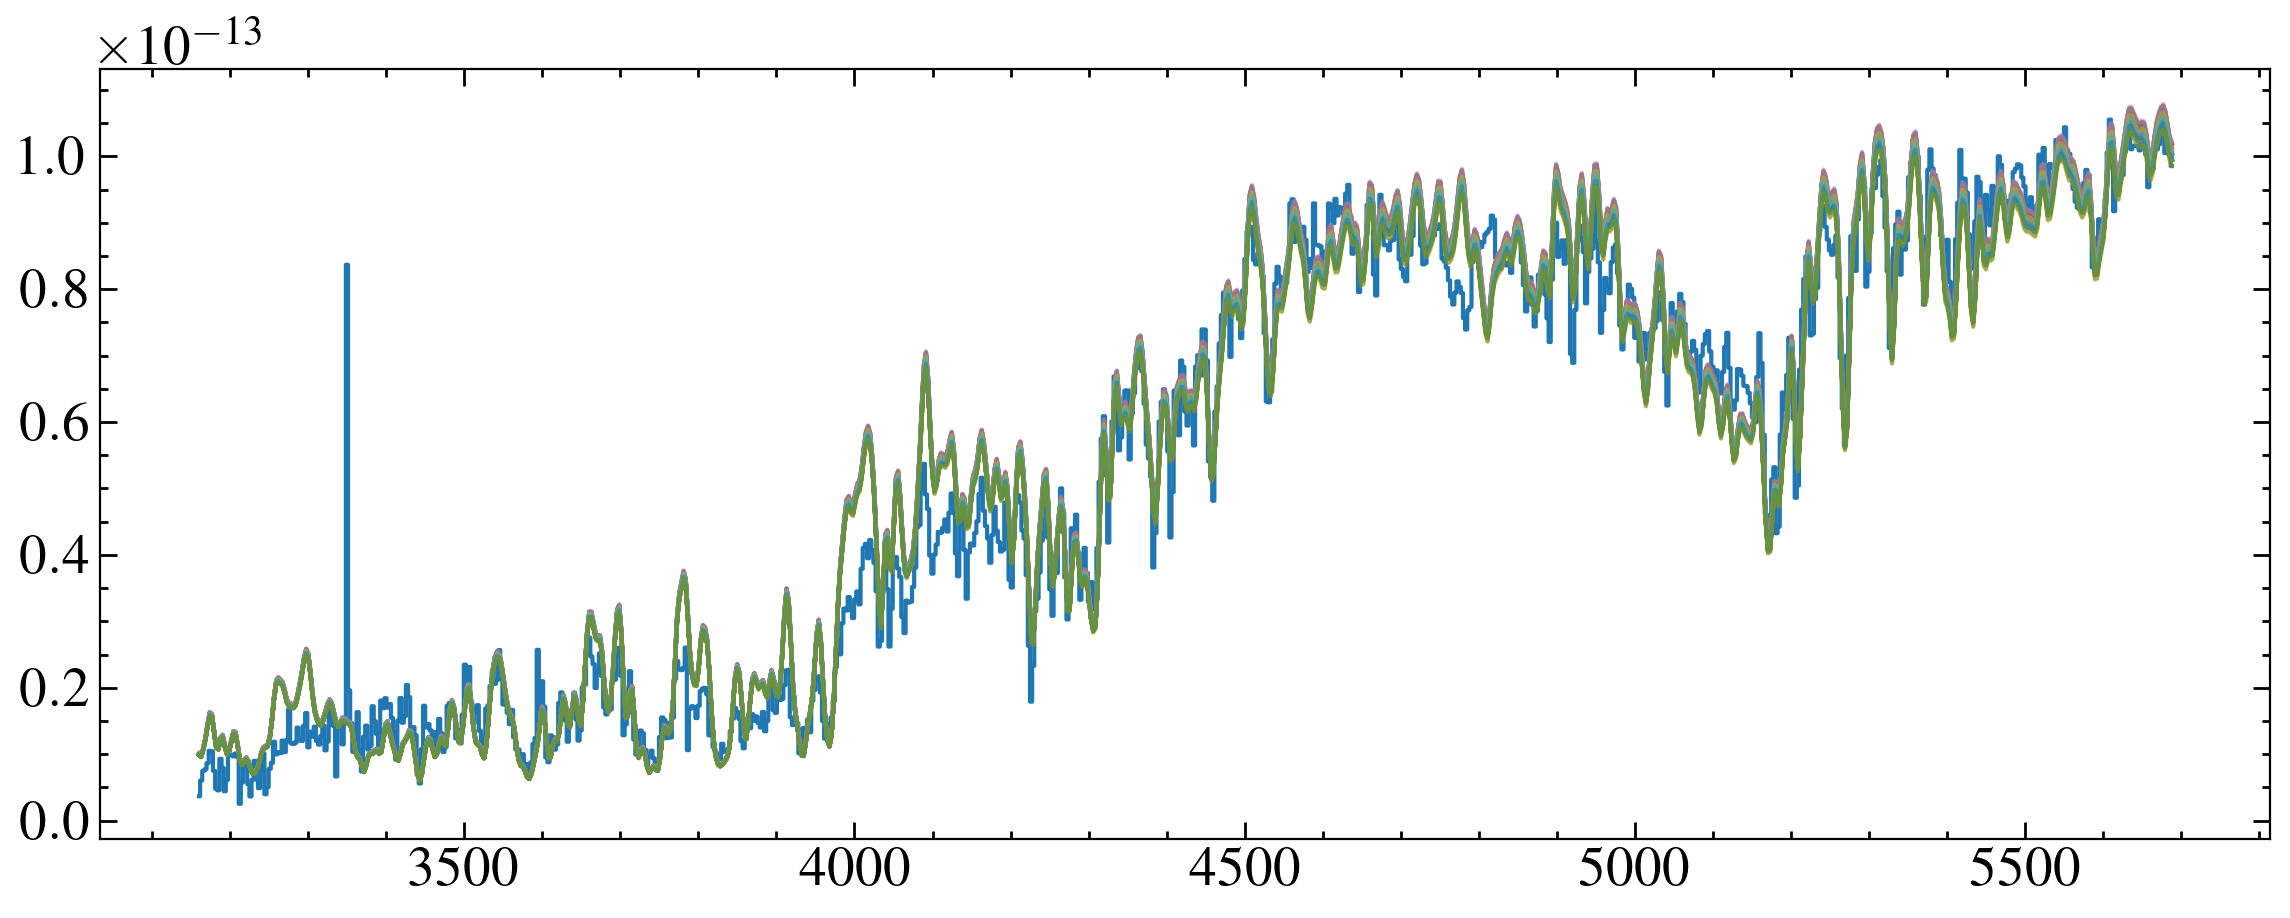

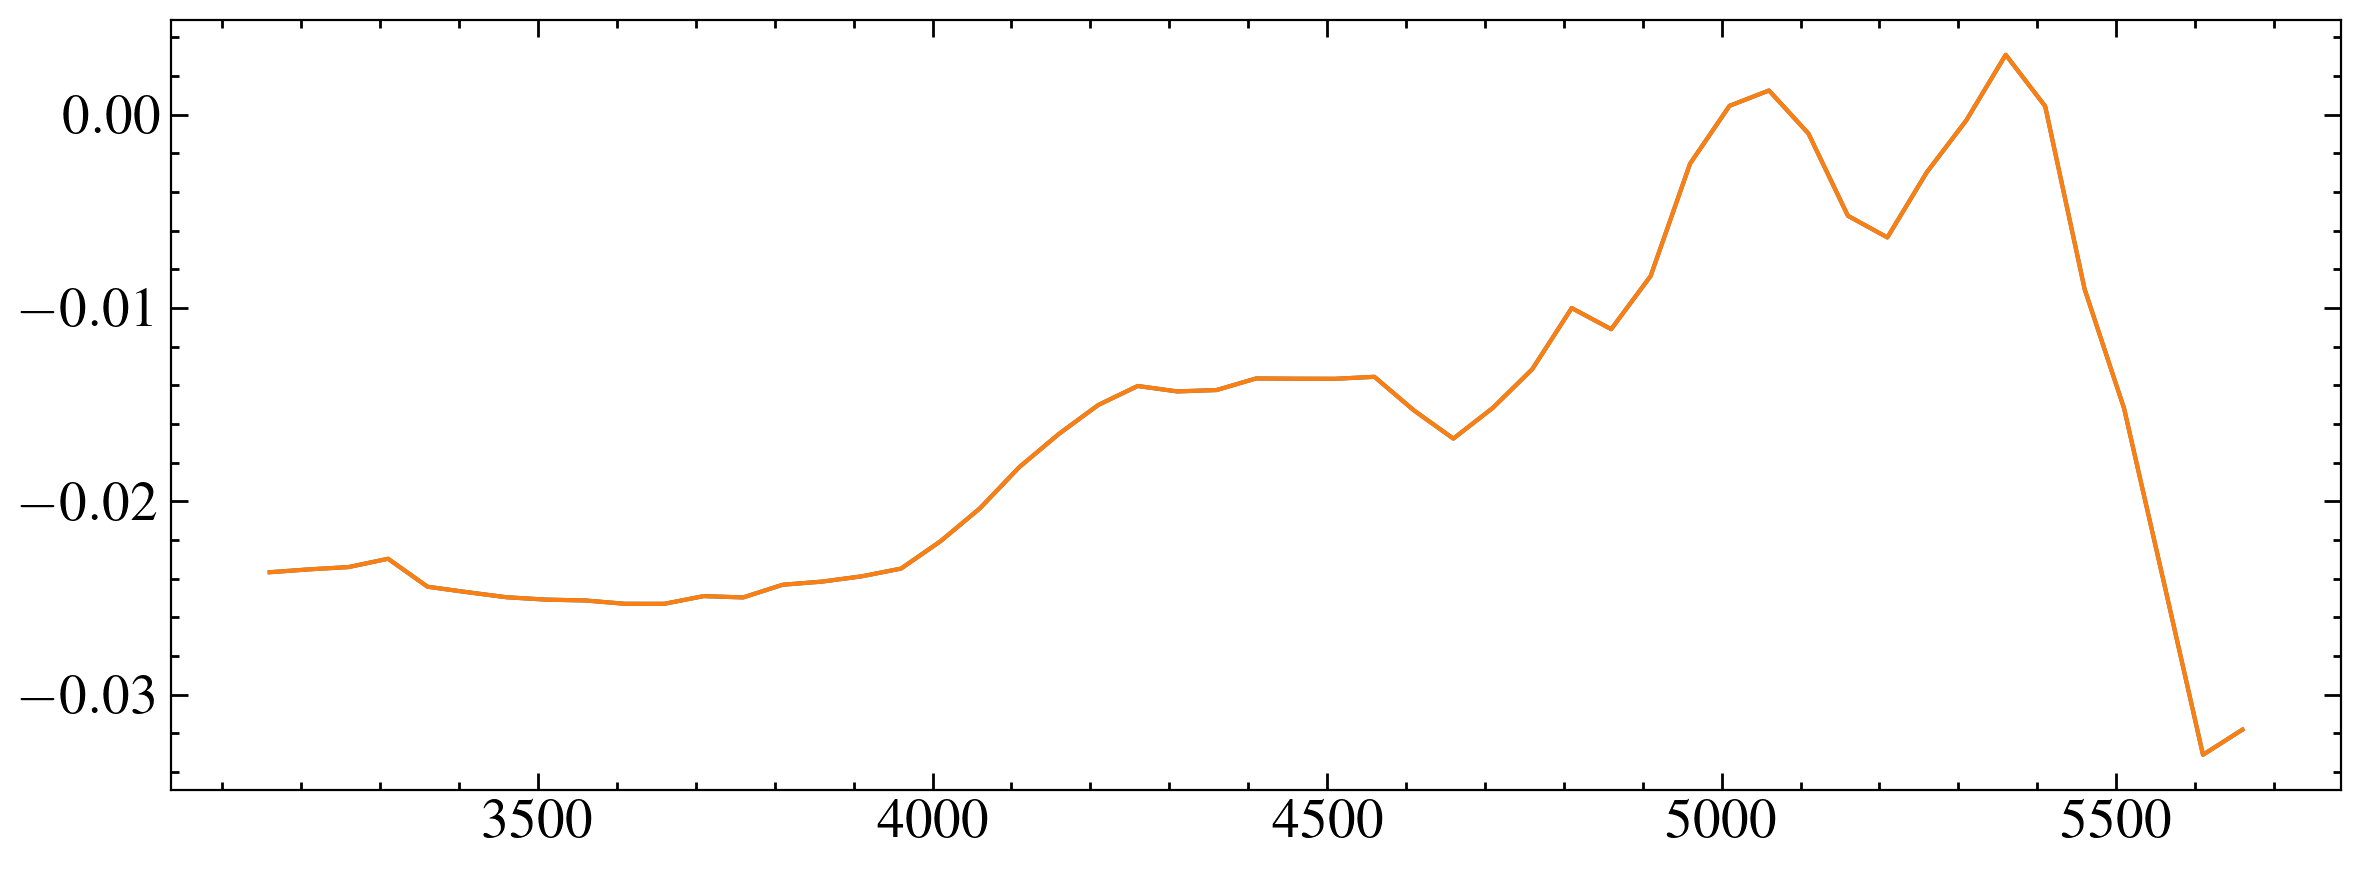

In [91]:
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.optimize import leastsq


def guass_smooth(wavelength, flux, A = 'none', R='none', Lambda = 'none'):
    """
    Takes a spectrum and Guassian smooths it either to a angstroms per resel A or an R value. If the wavelength Lambda at which R is evaluated is not supplied it takes the central wavelength of the spectrum.   
    """
    respix = (wavelength[-1] - wavelength[0])/len(wavelength)
    if A == 'none':
        try: 
            R != 'none'
        except:
            print('Error: I need either an Angstroms per resolution element A or a resolution R = Lambda/A')
            return
        if Lambda == 'none':
            Lambda = (wavelength[-1] + wavelength[0])/2 #mid point of spectrum
            print(Lambda)
        A = Lambda / R
        # print(A)
    FWHM = A/respix 
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
    f_smooth = convolve(flux, Gaussian1DKernel(sigma))
    return f_smooth
    

def residuals(scale, f, mf):
    return f - mf/scale
    
R = 500
A = 2.37
cenwave = 4300

fig, ax = plt.subplots()


# ax.step(ow, of, where='mid')
mask = (pw > ow[0]-100) & (pw < ow[-1]+100)
pwi, pfi = pw[mask], pf[mask]*normfac 

# ax.plot(pwi, pfi, alpha = 0.5)

# pfA = guass_smooth(pwi, pfi, A=A)
# ax.plot(pwi, pfA, alpha=0.5)

pfR = guass_smooth(pwi, pfi, R=R, Lambda=cenwave)
# ax.plot(pwi, pfR, alpha=0.5)

pfR = np.interp(ow, pwi, pfR)

# ax.plot(ow, pfR)
# ax.plot(ow, pfR/of)

# ax.set_yscale('log')

# ax.set_ylim(2e20, 9e20)
redo = ext.extinguish(ow*u.AA, Ebv = 0.045)


norm_mask = ow > 5000

norm = leastsq(residuals, normfac, args=(pfR[norm_mask], (of/redo)[norm_mask]))[0][0]
print(normfac)
print(1/norm)

ax.step(ow, of/redo, where='mid')
ax.plot(ow, pfR*norm)

flux_int = np.trapz(pfR*norm, ow)

starts = np.arange(ow[0], ow[-1], 50)
norms = []
fluxes = []
for start in starts:
    norm_mask = ow > start
    normi =leastsq(residuals, normfac, args=(pfR[norm_mask], (of/redo)[norm_mask]))[0][0]
    norms.append(normi)
    ax.plot(ow, pfR*normi, alpha=0.5)
    fluxi = np.trapz(pfR*normi, ow)
    fluxes.append(fluxi)
    
    


fig, ax = plt.subplots()

ax.plot(starts, (norms/norm)-1)
ax.plot(starts, (fluxes/flux_int)-1)
# ax.axhline(norm, ls='--', c='C2')
    

In [92]:
uvm2_ratio

1.6652403519276457

In [94]:
g430l = fits.open('draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits')
g430l[0].header['NORMFAC'] = 1/norm
g430l.writeto('draft_hlsp/k2-141/hlsp_muscles_hst_stis_k2-141_g430l_v1_component-spec.fits', overwrite=True)

In [97]:
starspec = fits.getdata('fixed_hlsp/k2-141/hlsp_muscles_multi_multi_k2-141_broadband_v25_adapt-const-res-sed.fits', 1)
starw, starf = starspec['WAVELENGTH'], starspec['FLUX']
sol = Table.read('Solar_1au_sed.ecsv')
sw, sf = sol['WAVELENGTH'], sol['FLUX']

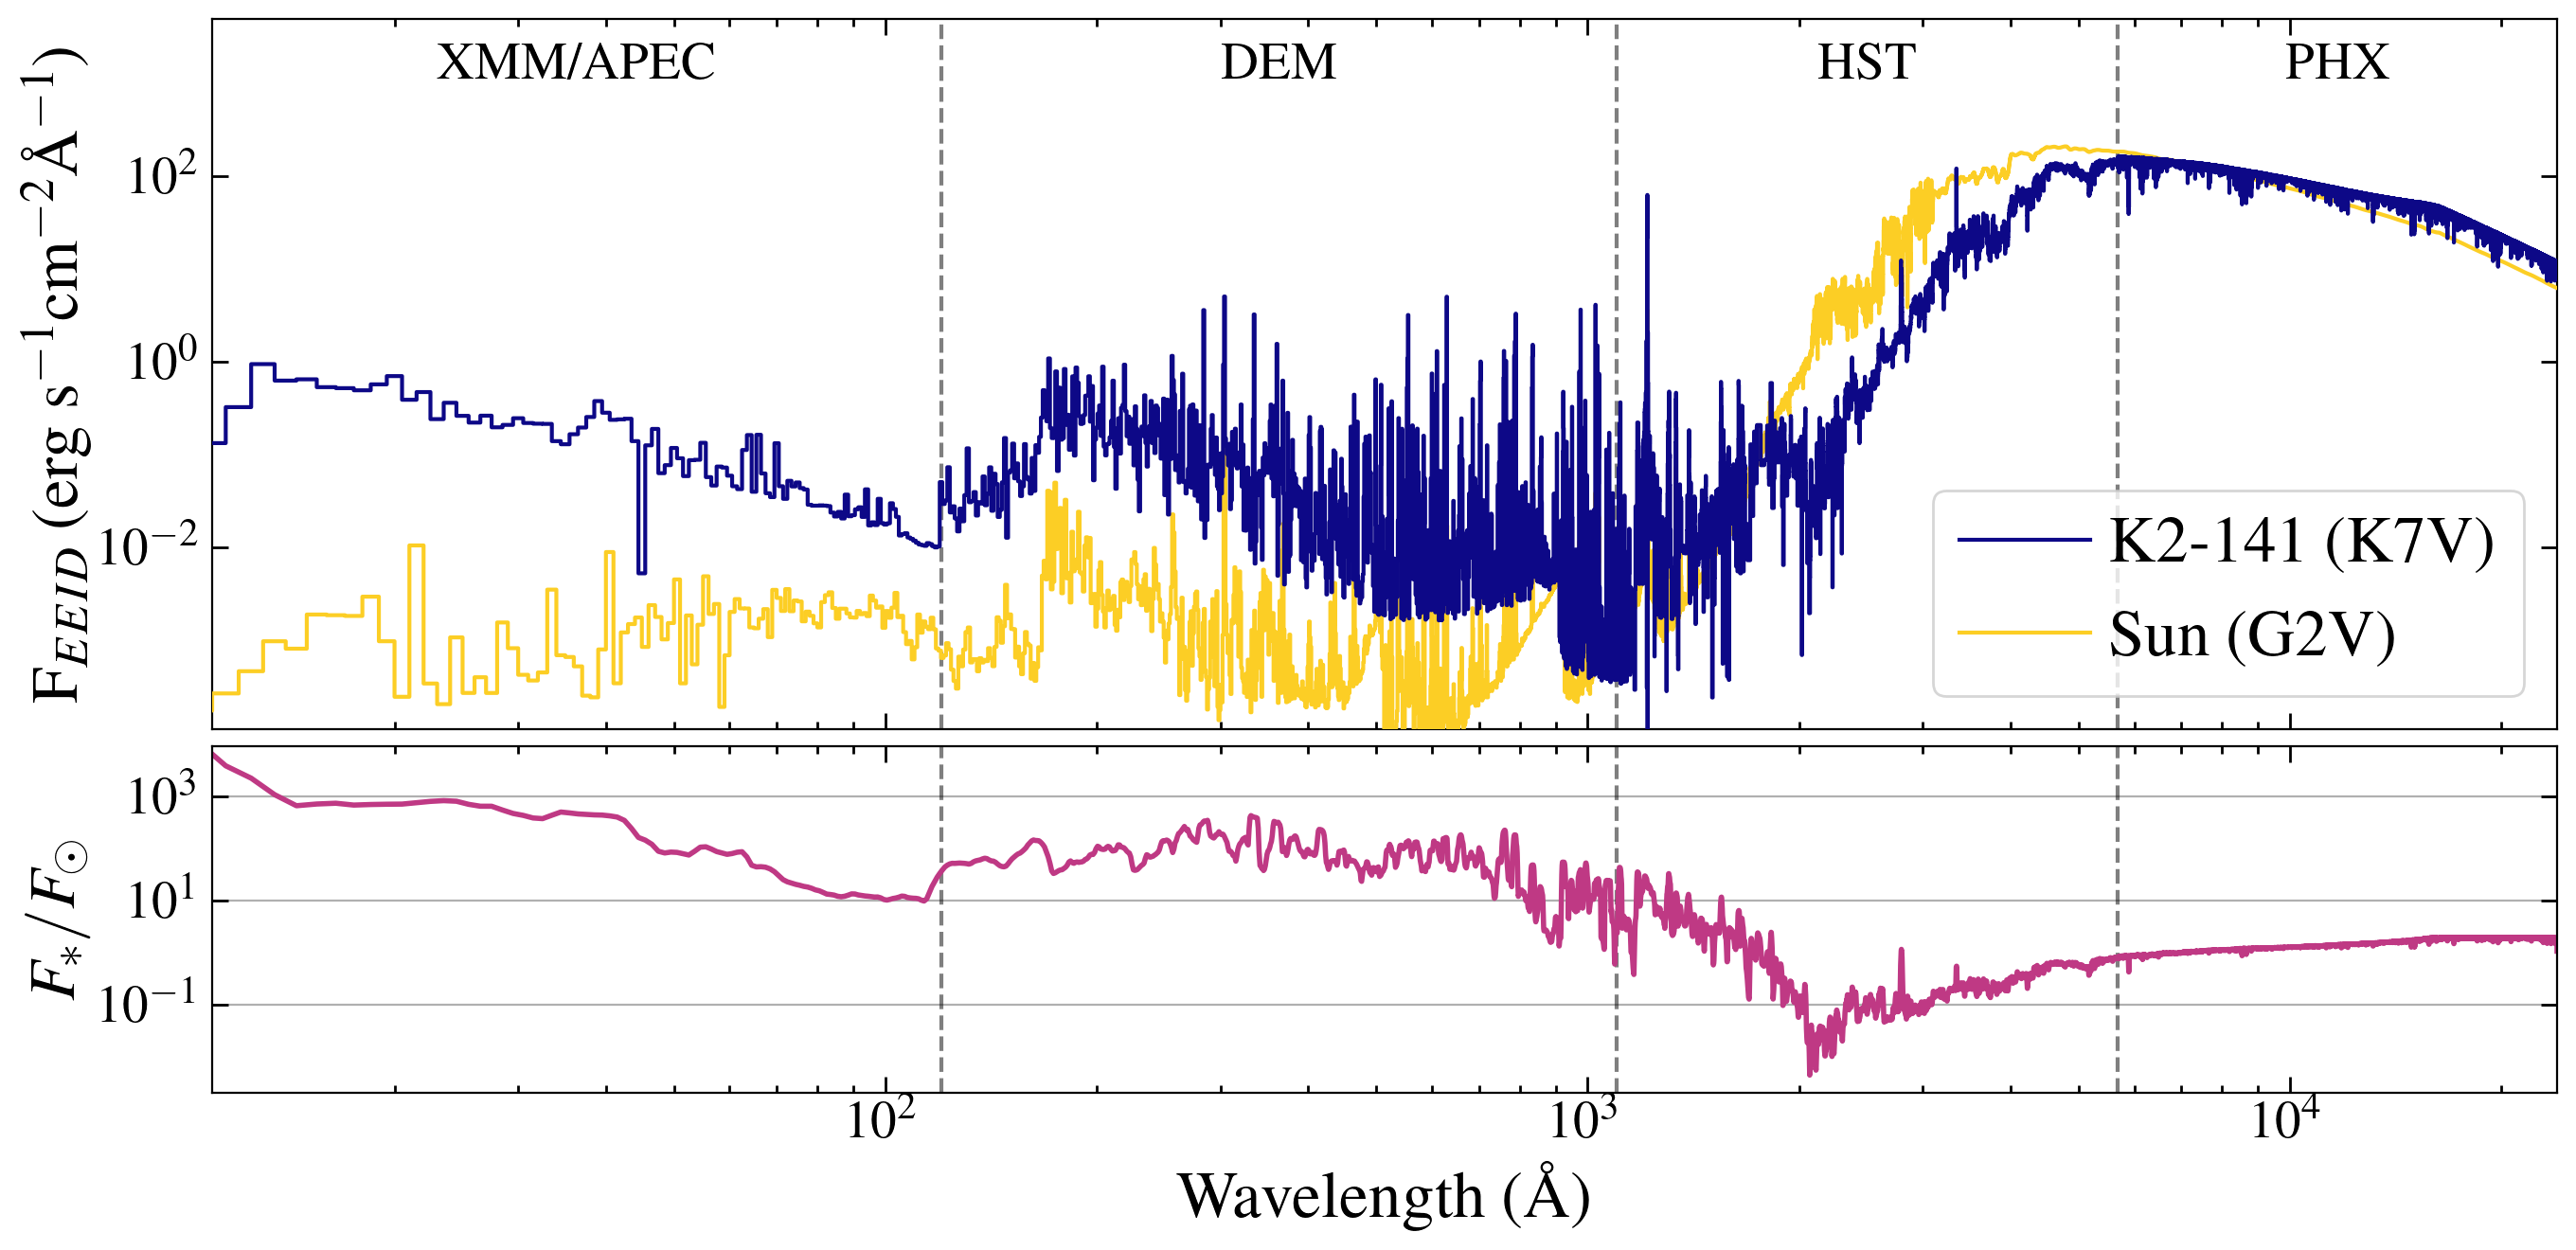

In [104]:

# cols = ['C0', 'C1', 'C2']
cols = [plt.cm.plasma(0),plt.cm.plasma(0.9), plt.cm.plasma(0.45)]

dstar = distance
dsun = 1*u.au
lstar = 10**-0.75
# eeidau = 0.471*u.au
eeidau = (lstar**0.5)*1*u.au

solscale = lstar*(dsun.to(u.m)/dstar.to(u.m))**2
starscale = ((dstar.to(u.m))/(eeidau.to(u.m)))**2

fig, axes = plt.subplot_mosaic([[0,0,0],[0,0,0],[1,1,1]],figsize=(14, 7), sharex=True)


ax= axes[0]
ax.step(starw, starf*starscale, c=cols[0], label = 'K2-141 (K7V)', zorder=12, where='mid')
ax.step(sw, sf, c=cols[1], label = 'Sun (G2V)', zorder=10, where='mid')
# ax.set_xlim(11, sw[-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.1e-4, 4.9e3)

bar_y = 1e3
label_y = bar_y*1.5
e_y = bar_y *0.3

xlims = (11, sw[-1])
ax.set_xlim(xlims[0], xlims[1])
divlines = (120, 1100, 5690)
[ax.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]

labels = ['XMM/APEC', 'DEM', 'HST', 'PHX']
labpos = np.sort(np.hstack((xlims, divlines)))

for i, label in enumerate(labels):
    label_x = (labpos[i]*labpos[i+1])**0.5
    ax.annotate(label, (label_x, label_y), ha='center', va='center')



ax.legend(fontsize=25, loc=4,frameon=True)
ax.set_ylabel('F$_{EEID}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)

ax1 = axes[1]
ax1.set_xlabel('Wavelength (\AA)', size=25)
[ax1.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]


mask = (starw> sw[0]) & (starw < sw[-1])
fnew = interp1d(starw[mask], starf[mask], fill_value='extrapolate')(sw)
fnew = fnew*starscale.value
ratio = fnew/sf
ratio = convolve(ratio,Box1DKernel(10))
ax1.plot(sw, ratio, c=cols[2], lw=2)
# ax1.set_ylim(0, 1000)

ax1.set_yscale('log')
ax1.set_ylim(2e-3, 9e3)
ax1.set_ylabel('$F_*/F_{\odot}$', size=25)
# ax1.axhline(1, ls='--', c='k', alpha=0.5)

ax1.grid(axis='y')
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


plt.savefig('plots/k2-141_v_sun.pdf')